#  <font color='#FFE16D'><b>Stroke Prediction Project (GNN bagging method)</b></font>

# 🔵 **Install Libs & Mount Google Drive**

In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.5 MB/s eta 0:00:00


In [ ]:
!pip install torch_geometric

!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.8/887.8 kB 56.3 MB/s eta 0:00:00


In [ ]:
!pip install -q tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🔵 **Import Libs**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score
from tqdm import tqdm

import torch.nn.functional as F

import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric import datasets

import random
import tensorboard

# 🔵 **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
  return nums

# 🔵 **Dataset**

In [ ]:
train_set = pd.read_csv('/content/drive/MyDrive/training_stroke1.csv')
test_set = pd.read_csv('/content/drive/MyDrive/testing_stroke1.csv')
train_set.shape, test_set.shape

((48200, 18), (200, 18))

In [ ]:
train_set.columns

Index(['Unnamed: 0', 'age', 'hypertension', 'heart_disease',
       'avg_glucose_level', 'bmi', 'smoking_status', 'gender_Female',
       'gender_Male', 'gender_Other', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'stroke'],
      dtype='object')

In [ ]:
train_set.isna().sum()

Unnamed: 0                 0
age                        0
hypertension               0
heart_disease              0
avg_glucose_level          0
bmi                        0
smoking_status             0
gender_Female              0
gender_Male                0
gender_Other               0
ever_married_Yes           0
work_type_Govt_job         0
work_type_Never_worked     0
work_type_Private          0
work_type_Self-employed    0
work_type_children         0
Residence_type_Rural       0
stroke                     0
dtype: int64

In [ ]:
test_set.isna().sum()

Unnamed: 0                 0
age                        0
hypertension               0
heart_disease              0
avg_glucose_level          0
bmi                        0
smoking_status             0
gender_Female              0
gender_Male                0
gender_Other               0
ever_married_Yes           0
work_type_Govt_job         0
work_type_Never_worked     0
work_type_Private          0
work_type_Self-employed    0
work_type_children         0
Residence_type_Rural       0
stroke                     0
dtype: int64

In [ ]:
train_set.drop(columns=['Unnamed: 0'], inplace=True)
test_set.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
train_set.describe().T

,count,mean,std,min,25%,50%,75%,max
age,48200.0,44.851100,23.115716,0.000000,27.00,47.00,63.000000,86.00
hypertension,48200.0,0.114274,0.318147,0.000000,0.00,0.00,0.000000,1.00
heart_disease,48200.0,0.057718,0.233212,0.000000,0.00,0.00,0.000000,1.00
avg_glucose_level,48200.0,107.099869,46.158383,40.268938,77.64,92.02,114.512487,291.05
bmi,48200.0,28.569090,7.423793,10.100000,23.50,28.10,32.400000,97.60
smoking_status,48200.0,0.491846,0.750233,0.000000,0.00,0.00,1.000000,2.00
gender_Female,48200.0,0.588174,0.492169,0.000000,0.00,1.00,1.000000,1.00
gender_Male,48200.0,0.411846,0.492173,0.000000,0.00,0.00,1.000000,1.00
gender_Other,48200.0,0.000228,0.015105,0.000000,0.00,0.00,0.000000,1.00
ever_married_Yes,48200.0,0.672386,0.469348,0.000000,0.00,1.00,1.000000,1.00


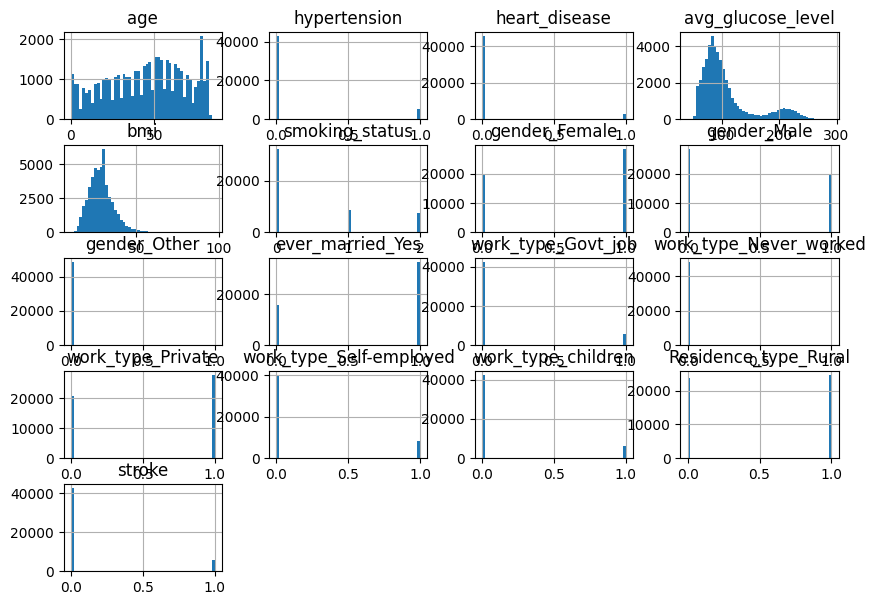

In [ ]:
train_set.hist(bins=50, figsize=(10, 7))
plt.show()

In [ ]:
corr_matrix = train_set.corr()
pd.set_option('display.max_columns', None)
corr_matrix

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,gender_Female,gender_Male,gender_Other,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,stroke
age,1.000000,0.274123,0.266252,0.245538,0.333512,0.192877,0.014306,-0.015478,-0.006502,0.690936,0.095286,-0.070986,0.108107,0.343800,-0.633147,0.010827,0.368819
hypertension,0.274123,1.000000,0.140472,0.155496,0.141429,0.055906,-0.032040,0.031015,-0.005159,0.175638,0.006339,-0.019546,-0.007046,0.122166,-0.130093,0.009778,0.122349
heart_disease,0.266252,0.140472,1.000000,0.144795,0.045939,0.069677,-0.086672,0.086071,-0.003757,0.136596,-0.021397,-0.015054,-0.038224,0.153462,-0.093975,0.018387,0.163459
avg_glucose_level,0.245538,0.155496,0.144795,1.000000,0.179641,0.066365,-0.045104,0.045745,-0.005857,0.159941,0.026403,-0.015454,0.007365,0.072809,-0.117022,0.004907,0.134301
bmi,0.333512,0.141429,0.045939,0.179641,1.000000,0.127211,0.014229,-0.014364,-0.000402,0.331751,0.089417,-0.022696,0.194903,0.064647,-0.449078,0.002425,0.055011
smoking_status,0.192877,0.055906,0.069677,0.066365,0.127211,1.000000,-0.028658,0.027771,0.004788,0.181579,0.047508,-0.028878,0.094617,0.049350,-0.238672,-0.005946,0.060724
gender_Female,0.014306,-0.032040,-0.086672,-0.045104,0.014229,-0.028658,1.000000,-0.992334,-0.018050,0.022317,0.045617,-0.002439,0.016368,0.008806,-0.081294,0.000321,-0.021390
gender_Male,-0.015478,0.031015,0.086071,0.045745,-0.014364,0.027771,-0.992334,1.000000,-0.012623,-0.022952,-0.045203,0.002549,-0.017348,-0.008651,0.081760,-0.000350,0.017876
gender_Other,-0.006502,-0.005159,-0.003757,-0.005857,-0.000402,0.004788,-0.018050,-0.012623,1.000000,-0.007113,0.002617,-0.000915,0.001998,-0.006900,0.002463,0.001269,-0.005524
ever_married_Yes,0.690936,0.175638,0.136596,0.159941,0.331751,0.181579,0.022317,-0.022952,-0.007113,1.000000,0.124560,-0.082112,0.142590,0.202449,-0.550836,0.001220,0.211082


<ipython-input-17-da03d5186282>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corr_matrix = corr_matrix.where(np.tril(np.ones(corr_matrix.shape)).astype(np.bool))


<Axes: >

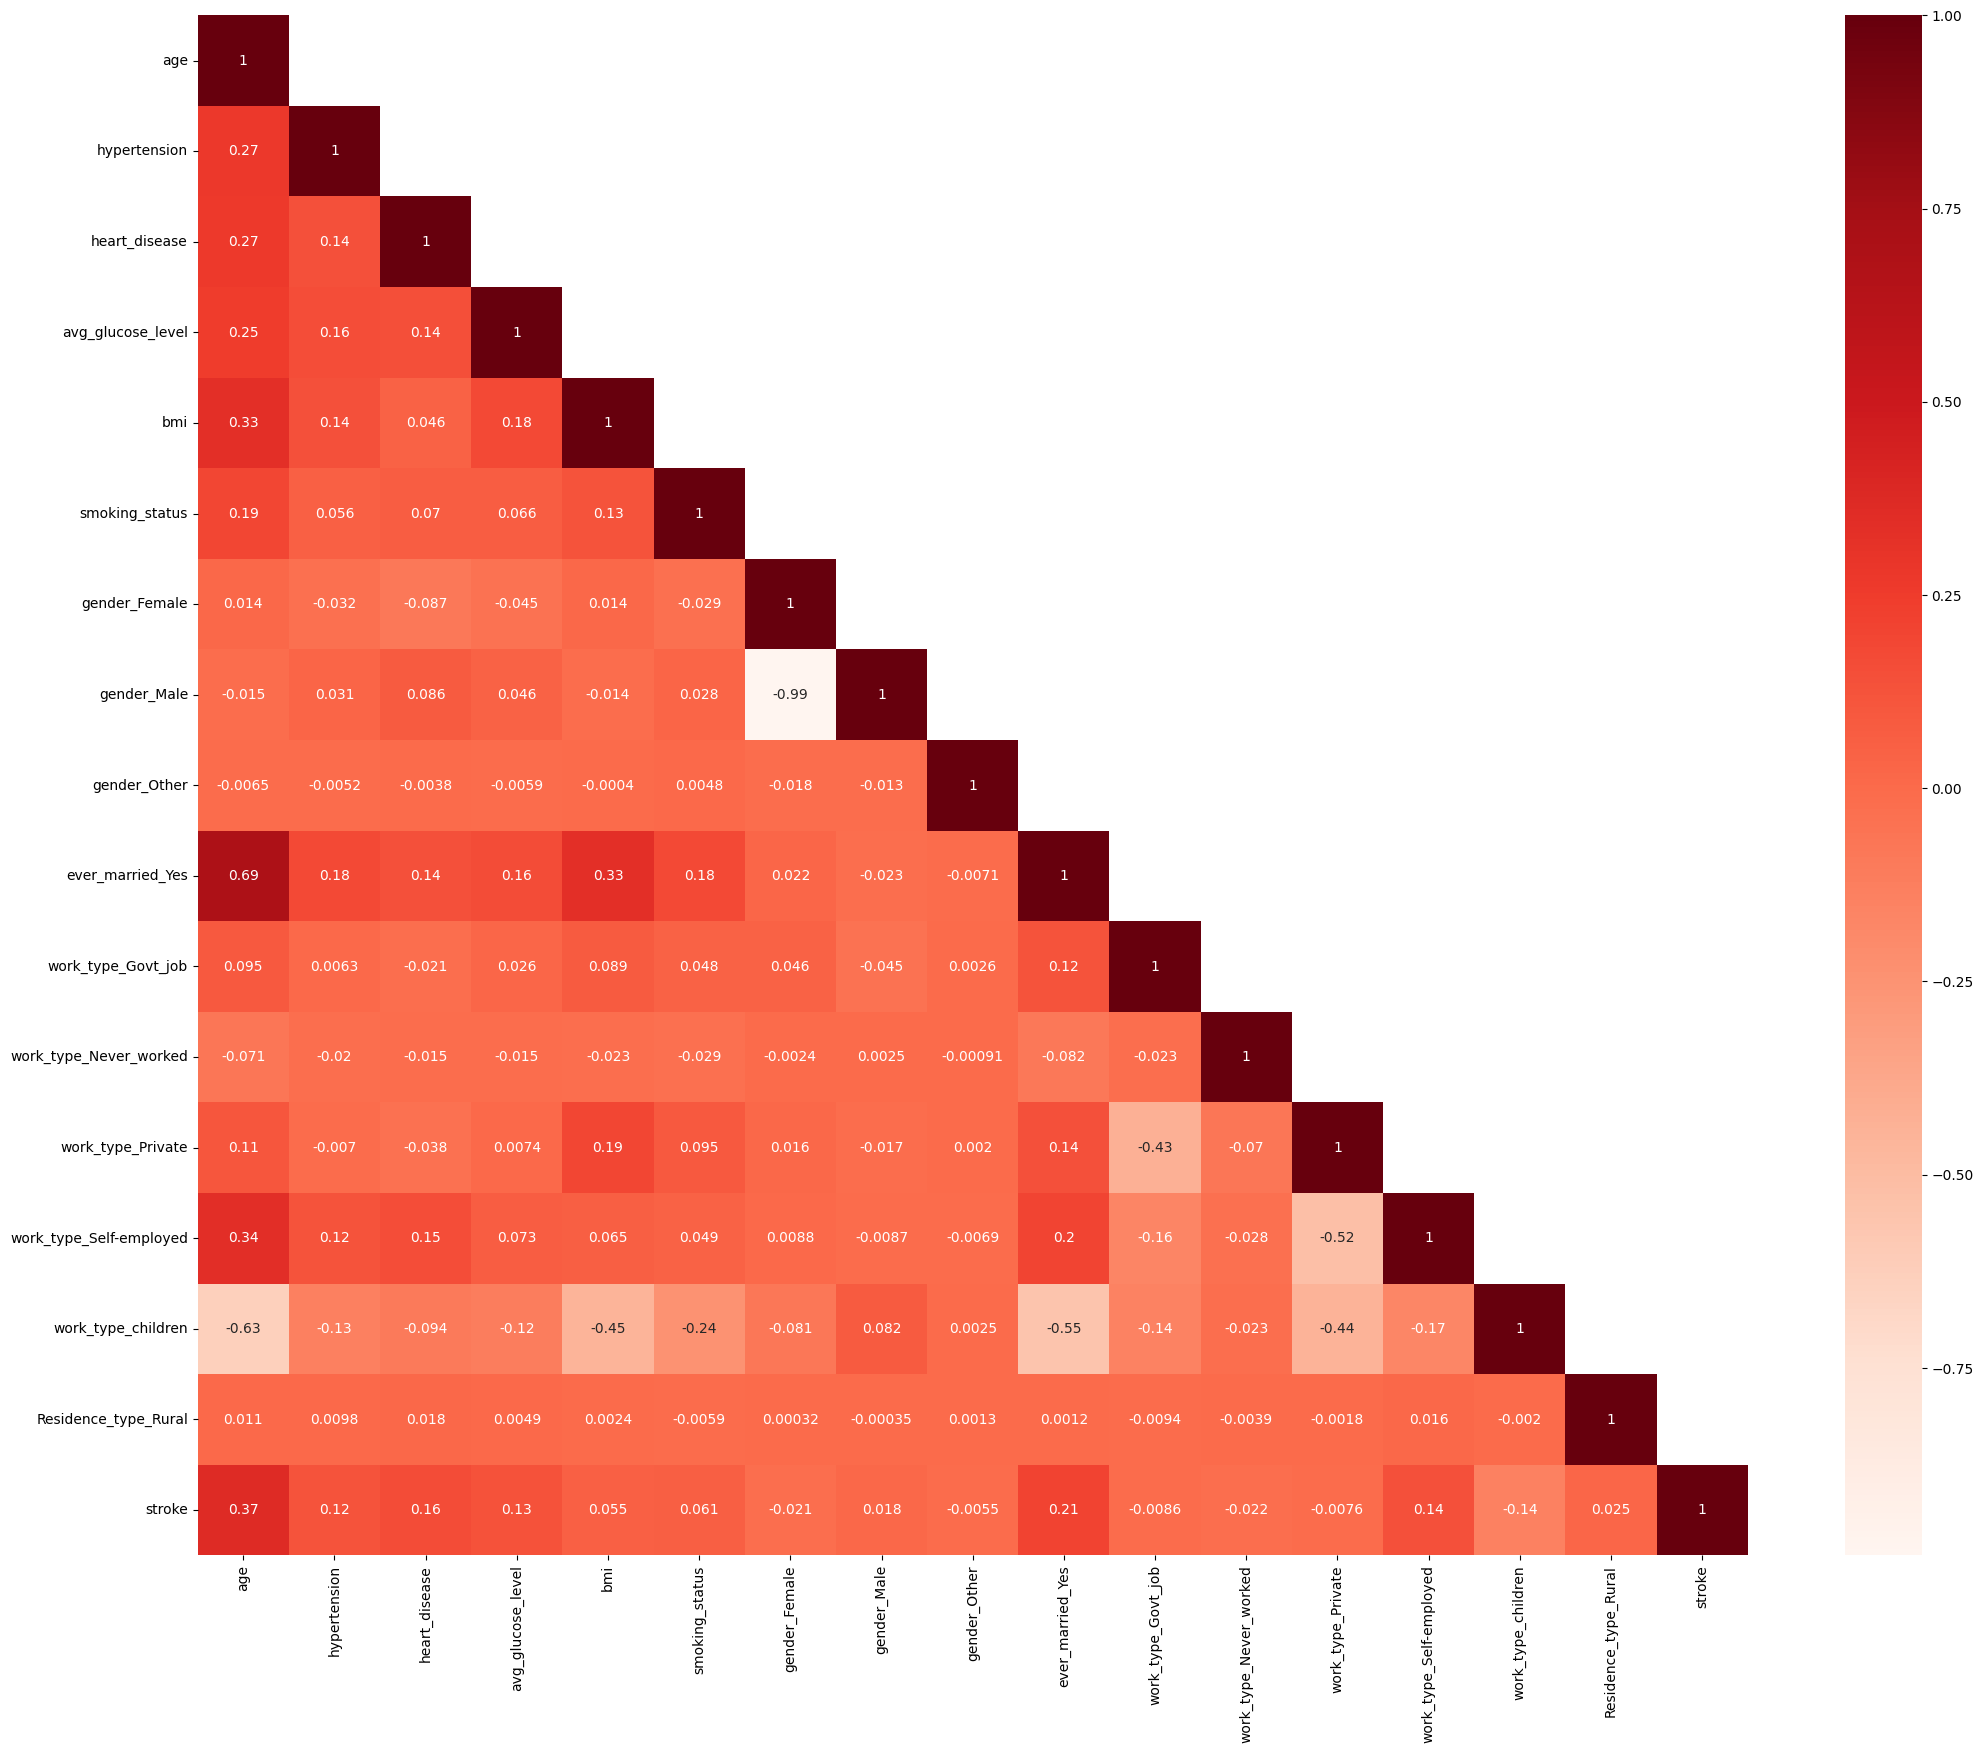

In [ ]:
plt.figure(figsize=(25, 20))
corr_matrix = corr_matrix.where(np.tril(np.ones(corr_matrix.shape)).astype(np.bool))
sns.heatmap(corr_matrix, annot=True, cmap='Reds')

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch, SpectralClustering
from sklearn.decomposition import PCA, KernelPCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap

In [ ]:
X = train_set.drop('stroke', axis=1)
y = train_set['stroke']

In [ ]:
x_standard = StandardScaler().fit_transform(X)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
import plotly

### PCA

In [ ]:
pca = PCA(n_components=2, random_state=42)
x_pca = pca.fit_transform(x_standard)

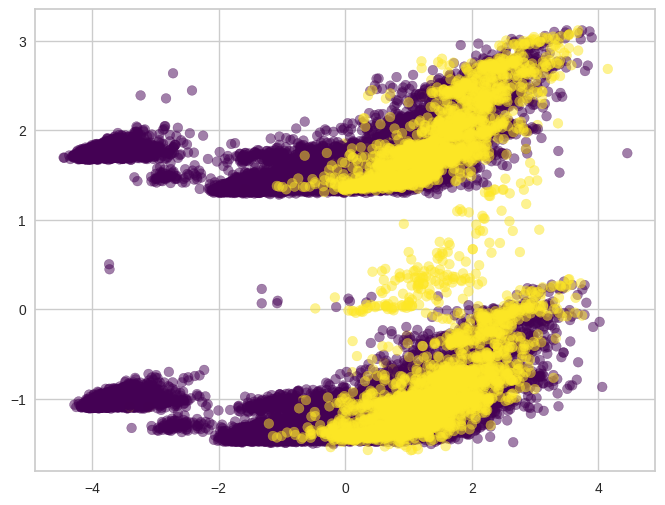

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.show()

In [ ]:
pca3d = PCA(n_components=3, random_state=42)
x_pca3d = pca3d.fit_transform(x_standard)

In [ ]:
fig = px.scatter_3d(pd.DataFrame(x_pca3d), x=0, y=1, z=2, color=y)
fig.show()

In [ ]:
train_set = train_set.sample(frac=1)
x = train_set.drop('stroke', axis=1)
y = train_set['stroke']

In [ ]:
def BaggingDataset(x, y, seed=100):
  bags_x, bags_y = [], []

  neg = y == 0
  pos = y == 1
  n_min = min(np.sum(neg), np.sum(pos))

  i = 1
  while (i - 1) * n_min <= np.sum(neg):
    neg_x = x[neg][(i - 1) * n_min:i * n_min] if i * n_min <= np.sum(neg) else x[neg][(i - 1) * n_min:]
    neg_y = y[neg][(i - 1) * n_min:i * n_min] if i * n_min <= np.sum(neg) else y[neg][(i - 1) * n_min:]

    pos_x = x[pos][0:n_min] if i * n_min <= np.sum(neg) else x[pos].sample(np.sum(neg) - (i - 1) * n_min, random_state=42)
    pos_y = y[pos][0:n_min] if i * n_min <= np.sum(neg) else y[pos].sample(np.sum(neg) - (i - 1) * n_min, random_state=42)

    cat_x = np.concatenate([neg_x, pos_x])
    np.random.seed(seed)
    np.random.shuffle(cat_x)
    cat_x = cat_x.tolist()
    cat_y = np.concatenate([neg_y, pos_y])
    np.random.seed(seed)
    np.random.shuffle(cat_y)
    cat_y = cat_y.tolist()

    bags_x.append(cat_x)
    bags_y.append(cat_y)
    i += 1

  return bags_x, bags_y

In [ ]:
bags_x, bags_y = BaggingDataset(x, y)

In [ ]:
def train_valid_bags(bags_x, bags_y):
  x_train_bags, x_valid_bags, y_train_bags, y_valid_bags = [], [], [], []

  for i in range(len(bags_x)):
    x_train, x_valid, y_train, y_valid = train_test_split(np.array(bags_x[i]), np.array(bags_y[i]), random_state=42, test_size=0.1, stratify=np.array(bags_y[i]))
    x_train_bags.append(x_train)
    x_valid_bags.append(x_valid)
    y_train_bags.append(y_train)
    y_valid_bags.append(y_valid)

  return x_train_bags, x_valid_bags, y_train_bags, y_valid_bags

In [ ]:
x_train_bags, x_valid_bags, y_train_bags, y_valid_bags = train_valid_bags(bags_x, bags_y)

In [ ]:
x_test = test_set.drop(['stroke'], axis=1)
y_test = test_set['stroke']

In [ ]:
def convert_bag_tensor(x_train_bags, x_valid_bags, x_test, y_train_bags, y_valid_bags, y_test):
  x_train_tensors, x_valid_tensors, x_test_tensors, y_train_tensors, y_valid_tensors, y_test_tensors = [], [], [], [], [], []

  for i in range(len(x_train_bags)):
    x_train = torch.FloatTensor(x_train_bags[i])
    y_train = torch.LongTensor(y_train_bags[i])

    x_valid = torch.FloatTensor(x_valid_bags[i])
    y_valid = torch.LongTensor(y_valid_bags[i])

    x_test_temp = torch.FloatTensor(x_test.values)
    y_test_temp = torch.LongTensor(y_test.values)

    mu = x_train.mean(dim=0)
    std = x_train.std(dim=0) + 1e-5

    x_train = (x_train - mu) / std
    x_valid = (x_valid - mu) / std
    x_test_temp = (x_test_temp - mu) / std

    x_train_tensors.append(x_train)
    x_valid_tensors.append(x_valid)
    x_test_tensors.append(x_test_temp)
    y_train_tensors.append(y_train)
    y_valid_tensors.append(y_valid)
    y_test_tensors.append(y_test_temp)

  return x_train_tensors, x_valid_tensors, x_test_tensors, y_train_tensors, y_valid_tensors, y_test_tensors

In [ ]:
x_train_tensors, x_valid_tensors, x_test_tensors, y_train_tensors, y_valid_tensors, y_test_tensors = convert_bag_tensor(x_train_bags,
                                                                                                                        x_valid_bags,
                                                                                                                        x_test,
                                                                                                                        y_train_bags,
                                                                                                                        y_valid_bags,
                                                                                                                        y_test)

In [ ]:
for i in range(len(x_test_tensors)):
  torch.save(x_test_tensors[i], f'/content/drive/MyDrive/x_test{i}_fold_1.pt')
  torch.save(y_test_tensors[i], f'/content/drive/MyDrive/y_test{i}_fold_1.pt')

In [ ]:
list_1 = []
num = 0
for i in range(15, 0, -1):
  list_1 += i * [num]
  num += 1

list_2 = []
for i in range(15):
  list_temp = []
  for j in range(i + 1, 16):
    list_temp.append(j)

  list_2 = [*list_2, *list_temp]

print(len(list_1))
print(len(list_2))

120
120


In [ ]:
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader

class StrokeDataset(Dataset):
  def __init__(self, x_data, y_data):
    super(StrokeDataset, self).__init__()
    self.graph_dataset = []
    for i in range(len(x_data)):
      x = x_data[i].unsqueeze(1)
      edge_index = torch.LongTensor([list_1, list_2])
      y = y_data[i].unsqueeze(0)
      data = Data(x=x, edge_index=edge_index, y=y)
      self.graph_dataset.append(data)

  def len(self):
    return len(self.graph_dataset)

  def get(self, index):
    data = self.graph_dataset[index]
    return data

In [ ]:
def bag_dataloader(x_train_tensors, x_valid_tensors, x_test_tensors, y_train_tensors, y_valid_tensors, y_test_tensors):
  train_loaders, valid_loaders, test_loaders = [], [], []

  for i in range(len(x_train_tensors)):
    train_dataset = StrokeDataset(x_train_tensors[i], y_train_tensors[i])
    train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

    valid_dataset = StrokeDataset(x_valid_tensors[i], y_valid_tensors[i])
    valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

    test_dataset = StrokeDataset(x_test_tensors[i], y_test_tensors[i])
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    train_loaders.append(train_loader)
    valid_loaders.append(valid_loader)
    test_loaders.append(test_loader)

  return train_loaders, valid_loaders, test_loaders

In [ ]:
train_loaders, valid_loaders, test_loaders = bag_dataloader(x_train_tensors,
                                                            x_valid_tensors,
                                                            x_test_tensors,
                                                            y_train_tensors,
                                                            y_valid_tensors,
                                                            y_test_tensors)

# 🔵 **Models**

In [ ]:
import torch_geometric.nn as gnn

class GNN(nn.Module):

  def __init__(self, hidden_channels):
    super(GNN, self).__init__()
    self.tconv1 = gnn.TransformerConv(1, 16*hidden_channels)
    self.tconv2 = gnn.TransformerConv(16*hidden_channels, 8*hidden_channels)
    self.tconv3 = gnn.TransformerConv(8*hidden_channels, 4*hidden_channels)
    self.tconv4 = gnn.TransformerConv(4*hidden_channels, 2*hidden_channels)
    self.tconv5 = gnn.TransformerConv(2*hidden_channels, hidden_channels)
    self.fc = nn.LazyLinear(1)

  def forward(self, x, edge_index, batch):
    x = F.relu(self.tconv1(x, edge_index))
    x = F.dropout(x, p=0.3, training=self.training)
    x = F.relu(self.tconv2(x, edge_index))
    x = F.dropout(x, p=0.3, training=self.training)
    x = F.relu(self.tconv3(x, edge_index))
    x = F.dropout(x, p=0.3, training=self.training)
    x = F.relu(self.tconv4(x, edge_index))
    x = F.relu(self.tconv5(x, edge_index))
    y = gnn.global_max_pool(x, batch)
    y = self.fc(y)
    return y

In [ ]:
model = GNN(hidden_channels=16)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# 🔵 **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = model.to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss()
metric = BinaryAccuracy().to(device)

# 🔵 **Train & Validation**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm(train_loader, unit="batch") as tepoch:
    for batch_data in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs, edge_index, batch, targets = batch_data.x, batch_data.edge_index, batch_data.batch, batch_data.y

      inputs = inputs.to(device)
      edge_index = edge_index.to(device)
      batch = batch.to(device)
      targets = targets.type(torch.FloatTensor)
      targets = targets.to(device)

      outputs = model(inputs, edge_index, batch).squeeze(1)
      loss = loss_fn(outputs, targets)
      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets.int())
      tepoch.set_postfix(Loss=loss_train.avg,
                        F1_Score=100.*metric.compute().item())
  return model, loss_train.avg, metric.compute().item()

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for i, batch_data in enumerate(test_loader):
      inputs, edge_index, batch, targets = batch_data.x, batch_data.edge_index, batch_data.batch, batch_data.y

      inputs = inputs.to(device)
      edge_index = edge_index.to(device)
      batch = batch.to(device)
      targets = targets.type(torch.FloatTensor)
      targets = targets.to(device)

      outputs = model(inputs, edge_index, batch).squeeze(1)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), len(targets))
      metric.update(outputs, targets.int())
  return loss_eval.avg, metric.compute().item()

# 🔵 **Training Process**

## 🔴 **Main Loop**

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epoch 0: 100%|██████████| 10/10 [00:01<00:00,  7.46batch/s, F1_Score=67, Loss=0.682]


Valid: Loss = 0.6647, F1_Score = 0.7726
Model Saved!



Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  7.93batch/s, F1_Score=77.1, Loss=0.646]


Valid: Loss = 0.627, F1_Score = 0.7768
Model Saved!



Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  7.88batch/s, F1_Score=76.9, Loss=0.601]


Valid: Loss = 0.5894, F1_Score = 0.7637
Model Saved!



Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  6.71batch/s, F1_Score=75.7, Loss=0.555]


Valid: Loss = 0.5429, F1_Score = 0.7613
Model Saved!



Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.72batch/s, F1_Score=76.4, Loss=0.516]


Valid: Loss = 0.5041, F1_Score = 0.7565
Model Saved!



Epoch 5: 100%|██████████| 10/10 [00:01<00:00,  6.87batch/s, F1_Score=76.6, Loss=0.495]


Valid: Loss = 0.4867, F1_Score = 0.7726
Model Saved!



Epoch 6: 100%|██████████| 10/10 [00:01<00:00,  7.95batch/s, F1_Score=77.2, Loss=0.487]


Valid: Loss = 0.4817, F1_Score = 0.7686
Model Saved!



Epoch 7: 100%|██████████| 10/10 [00:01<00:00,  7.82batch/s, F1_Score=77.5, Loss=0.485]


Valid: Loss = 0.4785, F1_Score = 0.7715
Model Saved!



Epoch 8: 100%|██████████| 10/10 [00:01<00:00,  7.79batch/s, F1_Score=77.5, Loss=0.483]


Valid: Loss = 0.4768, F1_Score = 0.7742
Model Saved!



Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  7.84batch/s, F1_Score=77.5, Loss=0.482]


Valid: Loss = 0.4765, F1_Score = 0.7684
Model Saved!



Epoch 10: 100%|██████████| 10/10 [00:01<00:00,  7.55batch/s, F1_Score=77.5, Loss=0.481]


Valid: Loss = 0.4747, F1_Score = 0.7796
Model Saved!



Epoch 11: 100%|██████████| 10/10 [00:01<00:00,  7.90batch/s, F1_Score=77.6, Loss=0.482]


Valid: Loss = 0.4742, F1_Score = 0.7728
Model Saved!



Epoch 12: 100%|██████████| 10/10 [00:01<00:00,  7.80batch/s, F1_Score=77.3, Loss=0.481]


Valid: Loss = 0.4745, F1_Score = 0.7656



Epoch 13: 100%|██████████| 10/10 [00:01<00:00,  6.62batch/s, F1_Score=77.5, Loss=0.481]


Valid: Loss = 0.4735, F1_Score = 0.7697
Model Saved!



Epoch 14: 100%|██████████| 10/10 [00:01<00:00,  6.68batch/s, F1_Score=77.3, Loss=0.479]


Valid: Loss = 0.4732, F1_Score = 0.768
Model Saved!



Epoch 15: 100%|██████████| 10/10 [00:01<00:00,  7.15batch/s, F1_Score=77.6, Loss=0.479]


Valid: Loss = 0.4759, F1_Score = 0.7562



Epoch 16: 100%|██████████| 10/10 [00:01<00:00,  7.96batch/s, F1_Score=77.6, Loss=0.48]


Valid: Loss = 0.4733, F1_Score = 0.7618



Epoch 17: 100%|██████████| 10/10 [00:01<00:00,  7.77batch/s, F1_Score=77, Loss=0.479]


Valid: Loss = 0.472, F1_Score = 0.7761
Model Saved!



Epoch 18: 100%|██████████| 10/10 [00:01<00:00,  7.82batch/s, F1_Score=77.7, Loss=0.478]


Valid: Loss = 0.4726, F1_Score = 0.7604



Epoch 19: 100%|██████████| 10/10 [00:01<00:00,  7.72batch/s, F1_Score=77.5, Loss=0.479]


Valid: Loss = 0.4724, F1_Score = 0.7583



Epoch 20: 100%|██████████| 10/10 [00:01<00:00,  7.91batch/s, F1_Score=77.4, Loss=0.479]


Valid: Loss = 0.4734, F1_Score = 0.7584



Epoch 21: 100%|██████████| 10/10 [00:01<00:00,  7.86batch/s, F1_Score=77.4, Loss=0.478]


Valid: Loss = 0.4727, F1_Score = 0.7582



Epoch 22: 100%|██████████| 10/10 [00:01<00:00,  7.80batch/s, F1_Score=77.2, Loss=0.477]


Valid: Loss = 0.4716, F1_Score = 0.7799
Model Saved!



Epoch 23: 100%|██████████| 10/10 [00:01<00:00,  6.67batch/s, F1_Score=77.8, Loss=0.477]


Valid: Loss = 0.4726, F1_Score = 0.7553



Epoch 24: 100%|██████████| 10/10 [00:01<00:00,  6.82batch/s, F1_Score=77.6, Loss=0.477]


Valid: Loss = 0.4756, F1_Score = 0.7528



Epoch 25: 100%|██████████| 10/10 [00:01<00:00,  7.01batch/s, F1_Score=77.2, Loss=0.478]


Valid: Loss = 0.4708, F1_Score = 0.7744
Model Saved!



Epoch 26: 100%|██████████| 10/10 [00:01<00:00,  7.63batch/s, F1_Score=77.5, Loss=0.477]


Valid: Loss = 0.4724, F1_Score = 0.7546



Epoch 27: 100%|██████████| 10/10 [00:01<00:00,  7.78batch/s, F1_Score=78, Loss=0.475]


Valid: Loss = 0.4734, F1_Score = 0.7519



Epoch 28: 100%|██████████| 10/10 [00:01<00:00,  7.93batch/s, F1_Score=77.2, Loss=0.477]


Valid: Loss = 0.4707, F1_Score = 0.7792
Model Saved!



Epoch 29: 100%|██████████| 10/10 [00:01<00:00,  7.85batch/s, F1_Score=77.5, Loss=0.476]


Valid: Loss = 0.4729, F1_Score = 0.7519



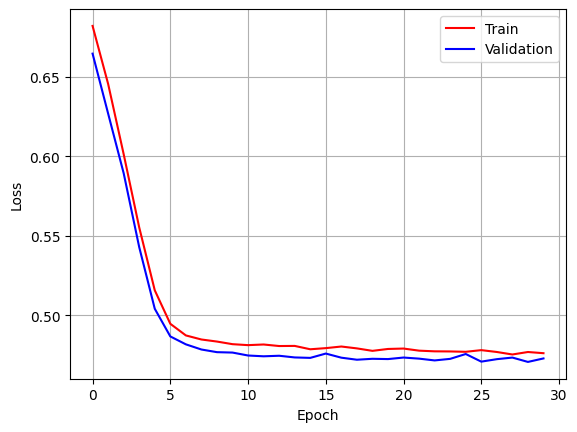

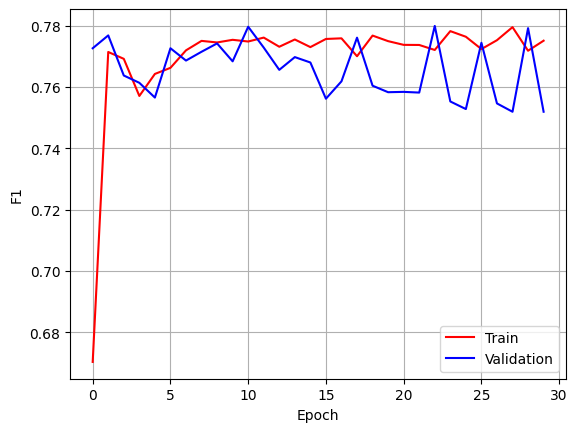

Epoch 0: 100%|██████████| 10/10 [00:01<00:00,  7.84batch/s, F1_Score=50.6, Loss=0.689]


Valid: Loss = 0.6749, F1_Score = 0.6999
Model Saved!



Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  7.83batch/s, F1_Score=76.1, Loss=0.662]


Valid: Loss = 0.6392, F1_Score = 0.7773
Model Saved!



Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  7.47batch/s, F1_Score=77, Loss=0.611]


Valid: Loss = 0.5732, F1_Score = 0.7635
Model Saved!



Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  6.58batch/s, F1_Score=76.2, Loss=0.542]


Valid: Loss = 0.5077, F1_Score = 0.7649
Model Saved!



Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.69batch/s, F1_Score=77.1, Loss=0.499]


Valid: Loss = 0.4865, F1_Score = 0.7752
Model Saved!



Epoch 5: 100%|██████████| 10/10 [00:01<00:00,  7.31batch/s, F1_Score=78, Loss=0.489]


Valid: Loss = 0.4834, F1_Score = 0.7771
Model Saved!



Epoch 6: 100%|██████████| 10/10 [00:01<00:00,  7.82batch/s, F1_Score=78.5, Loss=0.481]


Valid: Loss = 0.4817, F1_Score = 0.7825
Model Saved!



Epoch 7: 100%|██████████| 10/10 [00:01<00:00,  7.91batch/s, F1_Score=78.3, Loss=0.479]


Valid: Loss = 0.4795, F1_Score = 0.7847
Model Saved!



Epoch 8: 100%|██████████| 10/10 [00:01<00:00,  7.80batch/s, F1_Score=78.3, Loss=0.476]


Valid: Loss = 0.4767, F1_Score = 0.7843
Model Saved!



Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  7.71batch/s, F1_Score=78.1, Loss=0.476]


Valid: Loss = 0.475, F1_Score = 0.7823
Model Saved!



Epoch 10: 100%|██████████| 10/10 [00:01<00:00,  7.78batch/s, F1_Score=78.5, Loss=0.473]


Valid: Loss = 0.4735, F1_Score = 0.7744
Model Saved!



Epoch 11: 100%|██████████| 10/10 [00:01<00:00,  6.89batch/s, F1_Score=78.3, Loss=0.474]


Valid: Loss = 0.4766, F1_Score = 0.7895



Epoch 12: 100%|██████████| 10/10 [00:02<00:00,  3.51batch/s, F1_Score=78.1, Loss=0.473]


Valid: Loss = 0.4737, F1_Score = 0.779



Epoch 13: 100%|██████████| 10/10 [00:01<00:00,  6.12batch/s, F1_Score=78.4, Loss=0.47]


Valid: Loss = 0.4727, F1_Score = 0.7765
Model Saved!



Epoch 14: 100%|██████████| 10/10 [00:01<00:00,  6.19batch/s, F1_Score=78.4, Loss=0.471]


Valid: Loss = 0.4722, F1_Score = 0.7743
Model Saved!



Epoch 15: 100%|██████████| 10/10 [00:01<00:00,  6.35batch/s, F1_Score=78.1, Loss=0.47]


Valid: Loss = 0.4726, F1_Score = 0.7799



Epoch 16: 100%|██████████| 10/10 [00:01<00:00,  6.86batch/s, F1_Score=78.2, Loss=0.471]


Valid: Loss = 0.4715, F1_Score = 0.7763
Model Saved!



Epoch 17: 100%|██████████| 10/10 [00:01<00:00,  7.77batch/s, F1_Score=78.1, Loss=0.469]


Valid: Loss = 0.4706, F1_Score = 0.77
Model Saved!



Epoch 18: 100%|██████████| 10/10 [00:01<00:00,  6.24batch/s, F1_Score=78.2, Loss=0.469]


Valid: Loss = 0.4714, F1_Score = 0.7789



Epoch 19: 100%|██████████| 10/10 [00:01<00:00,  7.76batch/s, F1_Score=78.2, Loss=0.468]


Valid: Loss = 0.4705, F1_Score = 0.7722
Model Saved!



Epoch 20: 100%|██████████| 10/10 [00:01<00:00,  7.82batch/s, F1_Score=78.3, Loss=0.469]


Valid: Loss = 0.4703, F1_Score = 0.772
Model Saved!



Epoch 21: 100%|██████████| 10/10 [00:01<00:00,  7.64batch/s, F1_Score=78.2, Loss=0.468]


Valid: Loss = 0.4706, F1_Score = 0.7701



Epoch 22: 100%|██████████| 10/10 [00:01<00:00,  6.64batch/s, F1_Score=78, Loss=0.469]


Valid: Loss = 0.4707, F1_Score = 0.7841



Epoch 23: 100%|██████████| 10/10 [00:01<00:00,  6.60batch/s, F1_Score=78.3, Loss=0.467]


Valid: Loss = 0.4698, F1_Score = 0.7805
Model Saved!



Epoch 24: 100%|██████████| 10/10 [00:01<00:00,  6.99batch/s, F1_Score=78.5, Loss=0.467]


Valid: Loss = 0.4695, F1_Score = 0.7753
Model Saved!



Epoch 25: 100%|██████████| 10/10 [00:01<00:00,  7.76batch/s, F1_Score=78.4, Loss=0.467]


Valid: Loss = 0.4697, F1_Score = 0.7763



Epoch 26: 100%|██████████| 10/10 [00:01<00:00,  7.70batch/s, F1_Score=78.4, Loss=0.468]


Valid: Loss = 0.469, F1_Score = 0.7741
Model Saved!



Epoch 27: 100%|██████████| 10/10 [00:01<00:00,  7.75batch/s, F1_Score=78, Loss=0.467]


Valid: Loss = 0.4695, F1_Score = 0.7803



Epoch 28: 100%|██████████| 10/10 [00:01<00:00,  7.78batch/s, F1_Score=78.3, Loss=0.466]


Valid: Loss = 0.4693, F1_Score = 0.7806



Epoch 29: 100%|██████████| 10/10 [00:01<00:00,  7.57batch/s, F1_Score=78.4, Loss=0.466]


Valid: Loss = 0.4685, F1_Score = 0.7715
Model Saved!



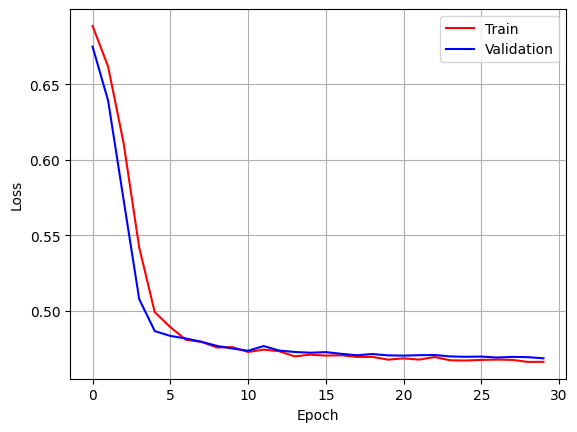

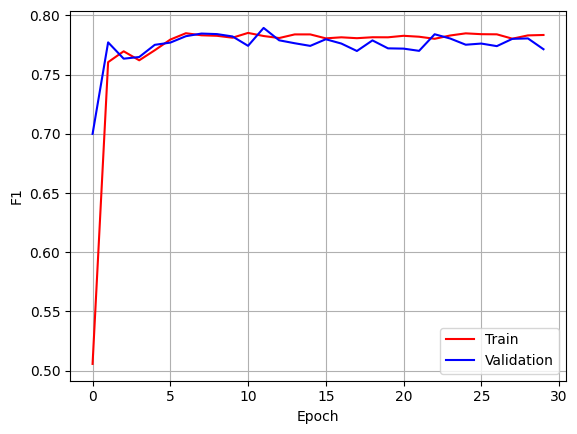

Epoch 0: 100%|██████████| 10/10 [00:01<00:00,  7.76batch/s, F1_Score=72, Loss=0.675]


Valid: Loss = 0.6542, F1_Score = 0.757
Model Saved!



Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  7.08batch/s, F1_Score=73.5, Loss=0.622]


Valid: Loss = 0.5867, F1_Score = 0.7578
Model Saved!



Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  6.81batch/s, F1_Score=76.9, Loss=0.542]


Valid: Loss = 0.5111, F1_Score = 0.7677
Model Saved!



Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  6.63batch/s, F1_Score=77.7, Loss=0.487]


Valid: Loss = 0.4939, F1_Score = 0.7707
Model Saved!



Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  7.18batch/s, F1_Score=78.2, Loss=0.48]


Valid: Loss = 0.4892, F1_Score = 0.7731
Model Saved!



Epoch 5: 100%|██████████| 10/10 [00:01<00:00,  7.69batch/s, F1_Score=78.4, Loss=0.478]


Valid: Loss = 0.4881, F1_Score = 0.776
Model Saved!



Epoch 6: 100%|██████████| 10/10 [00:01<00:00,  7.54batch/s, F1_Score=78.1, Loss=0.476]


Valid: Loss = 0.485, F1_Score = 0.777
Model Saved!



Epoch 7: 100%|██████████| 10/10 [00:01<00:00,  7.77batch/s, F1_Score=78.2, Loss=0.475]


Valid: Loss = 0.4809, F1_Score = 0.7622
Model Saved!



Epoch 8: 100%|██████████| 10/10 [00:01<00:00,  7.75batch/s, F1_Score=78.1, Loss=0.474]


Valid: Loss = 0.4805, F1_Score = 0.7704
Model Saved!



Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  7.76batch/s, F1_Score=78, Loss=0.473]


Valid: Loss = 0.4782, F1_Score = 0.762
Model Saved!



Epoch 10: 100%|██████████| 10/10 [00:01<00:00,  7.78batch/s, F1_Score=77.9, Loss=0.473]


Valid: Loss = 0.4817, F1_Score = 0.774



Epoch 11: 100%|██████████| 10/10 [00:01<00:00,  7.06batch/s, F1_Score=77.7, Loss=0.473]


Valid: Loss = 0.4825, F1_Score = 0.7761



Epoch 12: 100%|██████████| 10/10 [00:01<00:00,  6.62batch/s, F1_Score=78.2, Loss=0.475]


Valid: Loss = 0.4764, F1_Score = 0.7607
Model Saved!



Epoch 13: 100%|██████████| 10/10 [00:01<00:00,  6.57batch/s, F1_Score=78, Loss=0.472]


Valid: Loss = 0.4775, F1_Score = 0.774



Epoch 14: 100%|██████████| 10/10 [00:01<00:00,  7.32batch/s, F1_Score=77.9, Loss=0.471]


Valid: Loss = 0.4759, F1_Score = 0.7715
Model Saved!



Epoch 15: 100%|██████████| 10/10 [00:01<00:00,  7.74batch/s, F1_Score=78.2, Loss=0.471]


Valid: Loss = 0.4747, F1_Score = 0.7628
Model Saved!



Epoch 16: 100%|██████████| 10/10 [00:01<00:00,  7.71batch/s, F1_Score=78.2, Loss=0.471]


Valid: Loss = 0.4765, F1_Score = 0.7731



Epoch 17: 100%|██████████| 10/10 [00:01<00:00,  7.82batch/s, F1_Score=78.3, Loss=0.469]


Valid: Loss = 0.4745, F1_Score = 0.7637
Model Saved!



Epoch 18: 100%|██████████| 10/10 [00:01<00:00,  5.31batch/s, F1_Score=77.9, Loss=0.469]


Valid: Loss = 0.4744, F1_Score = 0.7743
Model Saved!



Epoch 19: 100%|██████████| 10/10 [00:01<00:00,  7.63batch/s, F1_Score=78, Loss=0.47]


Valid: Loss = 0.4737, F1_Score = 0.7716
Model Saved!



Epoch 20: 100%|██████████| 10/10 [00:01<00:00,  7.65batch/s, F1_Score=78, Loss=0.469]


Valid: Loss = 0.4732, F1_Score = 0.7716
Model Saved!



Epoch 21: 100%|██████████| 10/10 [00:01<00:00,  6.61batch/s, F1_Score=78.3, Loss=0.469]


Valid: Loss = 0.4728, F1_Score = 0.7718
Model Saved!



Epoch 22: 100%|██████████| 10/10 [00:01<00:00,  6.67batch/s, F1_Score=78.1, Loss=0.47]


Valid: Loss = 0.4728, F1_Score = 0.7742



Epoch 23: 100%|██████████| 10/10 [00:01<00:00,  6.67batch/s, F1_Score=77.8, Loss=0.468]


Valid: Loss = 0.4737, F1_Score = 0.773



Epoch 24: 100%|██████████| 10/10 [00:01<00:00,  7.72batch/s, F1_Score=78, Loss=0.468]


Valid: Loss = 0.4715, F1_Score = 0.769
Model Saved!



Epoch 25: 100%|██████████| 10/10 [00:01<00:00,  7.69batch/s, F1_Score=78, Loss=0.469]


Valid: Loss = 0.471, F1_Score = 0.7686
Model Saved!



Epoch 26: 100%|██████████| 10/10 [00:01<00:00,  7.64batch/s, F1_Score=78.2, Loss=0.468]


Valid: Loss = 0.4709, F1_Score = 0.7707
Model Saved!



Epoch 27: 100%|██████████| 10/10 [00:01<00:00,  7.67batch/s, F1_Score=78.1, Loss=0.468]


Valid: Loss = 0.4711, F1_Score = 0.7726



Epoch 28: 100%|██████████| 10/10 [00:01<00:00,  7.69batch/s, F1_Score=77.9, Loss=0.469]


Valid: Loss = 0.4716, F1_Score = 0.7764



Epoch 29: 100%|██████████| 10/10 [00:01<00:00,  7.68batch/s, F1_Score=78, Loss=0.469]


Valid: Loss = 0.4702, F1_Score = 0.7745
Model Saved!



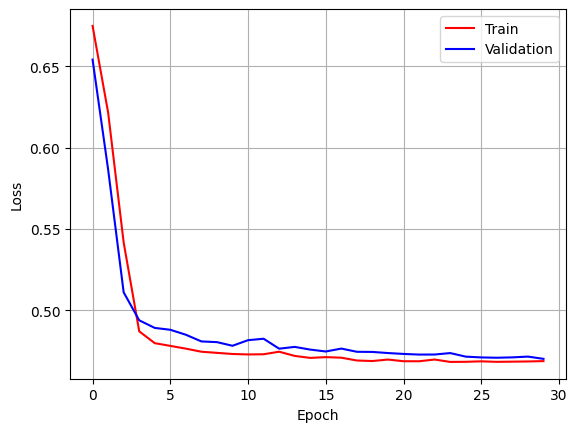

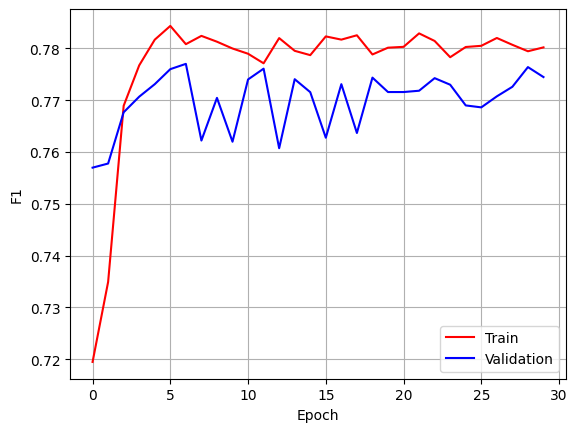

Epoch 0: 100%|██████████| 10/10 [00:01<00:00,  7.18batch/s, F1_Score=73.5, Loss=0.673]


Valid: Loss = 0.6459, F1_Score = 0.7782
Model Saved!



Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  6.78batch/s, F1_Score=76, Loss=0.616]


Valid: Loss = 0.5802, F1_Score = 0.7588
Model Saved!



Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  6.66batch/s, F1_Score=75.2, Loss=0.551]


Valid: Loss = 0.519, F1_Score = 0.7635
Model Saved!



Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  6.85batch/s, F1_Score=76.4, Loss=0.507]


Valid: Loss = 0.4914, F1_Score = 0.7842
Model Saved!



Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  7.64batch/s, F1_Score=77.2, Loss=0.492]


Valid: Loss = 0.4858, F1_Score = 0.7948
Model Saved!



Epoch 5: 100%|██████████| 10/10 [00:01<00:00,  7.57batch/s, F1_Score=78.1, Loss=0.487]


Valid: Loss = 0.478, F1_Score = 0.7862
Model Saved!



Epoch 6: 100%|██████████| 10/10 [00:01<00:00,  7.62batch/s, F1_Score=77.9, Loss=0.486]


Valid: Loss = 0.4766, F1_Score = 0.7928
Model Saved!



Epoch 7: 100%|██████████| 10/10 [00:01<00:00,  7.64batch/s, F1_Score=77.6, Loss=0.482]


Valid: Loss = 0.4776, F1_Score = 0.7928



Epoch 8: 100%|██████████| 10/10 [00:01<00:00,  7.66batch/s, F1_Score=78, Loss=0.479]


Valid: Loss = 0.4764, F1_Score = 0.7919
Model Saved!



Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  7.70batch/s, F1_Score=77.8, Loss=0.48]


Valid: Loss = 0.4732, F1_Score = 0.7869
Model Saved!



Epoch 10: 100%|██████████| 10/10 [00:01<00:00,  7.29batch/s, F1_Score=77.7, Loss=0.48]


Valid: Loss = 0.477, F1_Score = 0.7916



Epoch 11: 100%|██████████| 10/10 [00:01<00:00,  6.70batch/s, F1_Score=77.6, Loss=0.477]


Valid: Loss = 0.4736, F1_Score = 0.7902



Epoch 12: 100%|██████████| 10/10 [00:01<00:00,  6.73batch/s, F1_Score=78, Loss=0.477]


Valid: Loss = 0.4712, F1_Score = 0.7875
Model Saved!



Epoch 13: 100%|██████████| 10/10 [00:01<00:00,  6.77batch/s, F1_Score=77.5, Loss=0.477]


Valid: Loss = 0.4796, F1_Score = 0.7899



Epoch 14: 100%|██████████| 10/10 [00:01<00:00,  7.60batch/s, F1_Score=77.4, Loss=0.478]


Valid: Loss = 0.4738, F1_Score = 0.7919



Epoch 15: 100%|██████████| 10/10 [00:01<00:00,  7.70batch/s, F1_Score=77.7, Loss=0.475]


Valid: Loss = 0.4705, F1_Score = 0.7888
Model Saved!



Epoch 16: 100%|██████████| 10/10 [00:01<00:00,  7.64batch/s, F1_Score=77.8, Loss=0.475]


Valid: Loss = 0.471, F1_Score = 0.7873



Epoch 17: 100%|██████████| 10/10 [00:01<00:00,  7.70batch/s, F1_Score=77.7, Loss=0.475]


Valid: Loss = 0.4702, F1_Score = 0.7878
Model Saved!



Epoch 18: 100%|██████████| 10/10 [00:01<00:00,  7.69batch/s, F1_Score=77.5, Loss=0.474]


Valid: Loss = 0.4699, F1_Score = 0.7917
Model Saved!



Epoch 19: 100%|██████████| 10/10 [00:01<00:00,  7.62batch/s, F1_Score=77.5, Loss=0.474]


Valid: Loss = 0.4725, F1_Score = 0.7899



Epoch 20: 100%|██████████| 10/10 [00:01<00:00,  7.41batch/s, F1_Score=77.8, Loss=0.473]


Valid: Loss = 0.472, F1_Score = 0.7864



Epoch 21: 100%|██████████| 10/10 [00:01<00:00,  6.60batch/s, F1_Score=77.5, Loss=0.473]


Valid: Loss = 0.4692, F1_Score = 0.7861
Model Saved!



Epoch 22: 100%|██████████| 10/10 [00:01<00:00,  6.43batch/s, F1_Score=77.8, Loss=0.473]


Valid: Loss = 0.469, F1_Score = 0.7893
Model Saved!



Epoch 23: 100%|██████████| 10/10 [00:01<00:00,  6.91batch/s, F1_Score=77.7, Loss=0.472]


Valid: Loss = 0.4715, F1_Score = 0.7934



Epoch 24: 100%|██████████| 10/10 [00:01<00:00,  7.72batch/s, F1_Score=77.8, Loss=0.473]


Valid: Loss = 0.4685, F1_Score = 0.7865
Model Saved!



Epoch 25: 100%|██████████| 10/10 [00:01<00:00,  7.69batch/s, F1_Score=77.7, Loss=0.473]


Valid: Loss = 0.473, F1_Score = 0.7938



Epoch 26: 100%|██████████| 10/10 [00:01<00:00,  7.70batch/s, F1_Score=77.6, Loss=0.472]


Valid: Loss = 0.4677, F1_Score = 0.783
Model Saved!



Epoch 27: 100%|██████████| 10/10 [00:01<00:00,  7.58batch/s, F1_Score=78, Loss=0.472]


Valid: Loss = 0.4677, F1_Score = 0.7825



Epoch 28: 100%|██████████| 10/10 [00:01<00:00,  7.66batch/s, F1_Score=77.3, Loss=0.473]


Valid: Loss = 0.472, F1_Score = 0.7941



Epoch 29: 100%|██████████| 10/10 [00:01<00:00,  5.57batch/s, F1_Score=77.7, Loss=0.472]


Valid: Loss = 0.4682, F1_Score = 0.7869



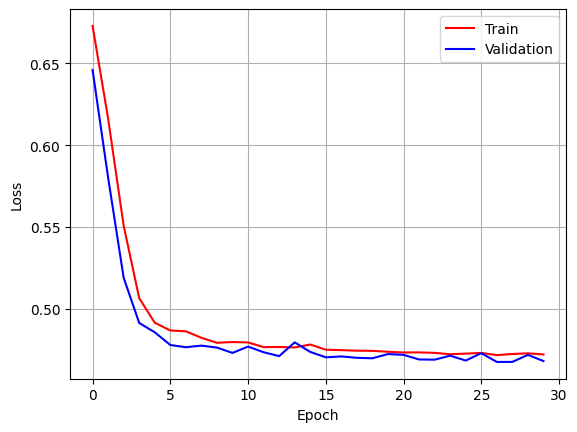

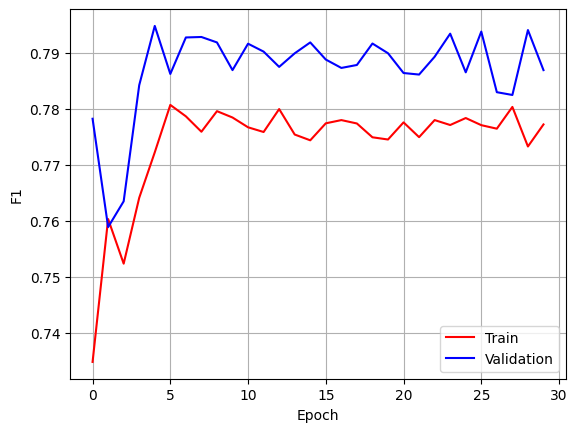

Epoch 0: 100%|██████████| 10/10 [00:01<00:00,  6.67batch/s, F1_Score=37.5, Loss=0.688]


Valid: Loss = 0.6673, F1_Score = 0.6991
Model Saved!



Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  6.66batch/s, F1_Score=75.6, Loss=0.646]


Valid: Loss = 0.6122, F1_Score = 0.7859
Model Saved!



Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  6.57batch/s, F1_Score=76.9, Loss=0.587]


Valid: Loss = 0.5434, F1_Score = 0.7725
Model Saved!



Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  7.53batch/s, F1_Score=76.4, Loss=0.525]


Valid: Loss = 0.4857, F1_Score = 0.7798
Model Saved!



Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  7.62batch/s, F1_Score=77, Loss=0.491]


Valid: Loss = 0.4669, F1_Score = 0.7771
Model Saved!



Epoch 5: 100%|██████████| 10/10 [00:01<00:00,  7.68batch/s, F1_Score=77.7, Loss=0.485]


Valid: Loss = 0.4596, F1_Score = 0.7864
Model Saved!



Epoch 6: 100%|██████████| 10/10 [00:01<00:00,  7.59batch/s, F1_Score=77.9, Loss=0.48]


Valid: Loss = 0.4575, F1_Score = 0.7962
Model Saved!



Epoch 7: 100%|██████████| 10/10 [00:01<00:00,  7.53batch/s, F1_Score=78, Loss=0.48]


Valid: Loss = 0.4549, F1_Score = 0.7902
Model Saved!



Epoch 8: 100%|██████████| 10/10 [00:01<00:00,  7.54batch/s, F1_Score=78.1, Loss=0.477]


Valid: Loss = 0.4539, F1_Score = 0.783
Model Saved!



Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  7.63batch/s, F1_Score=77.7, Loss=0.476]


Valid: Loss = 0.4525, F1_Score = 0.7868
Model Saved!



Epoch 10: 100%|██████████| 10/10 [00:01<00:00,  6.45batch/s, F1_Score=77.9, Loss=0.475]


Valid: Loss = 0.4519, F1_Score = 0.7795
Model Saved!



Epoch 11: 100%|██████████| 10/10 [00:01<00:00,  6.55batch/s, F1_Score=77.7, Loss=0.476]


Valid: Loss = 0.4507, F1_Score = 0.7775
Model Saved!



Epoch 12: 100%|██████████| 10/10 [00:01<00:00,  6.53batch/s, F1_Score=77.5, Loss=0.475]


Valid: Loss = 0.4513, F1_Score = 0.7768



Epoch 13: 100%|██████████| 10/10 [00:01<00:00,  7.56batch/s, F1_Score=77.5, Loss=0.473]


Valid: Loss = 0.4528, F1_Score = 0.7933



Epoch 14: 100%|██████████| 10/10 [00:01<00:00,  7.57batch/s, F1_Score=77.6, Loss=0.474]


Valid: Loss = 0.4517, F1_Score = 0.7746



Epoch 15: 100%|██████████| 10/10 [00:01<00:00,  7.50batch/s, F1_Score=77.7, Loss=0.473]


Valid: Loss = 0.4504, F1_Score = 0.7814
Model Saved!



Epoch 16: 100%|██████████| 10/10 [00:01<00:00,  7.61batch/s, F1_Score=77.6, Loss=0.473]


Valid: Loss = 0.4506, F1_Score = 0.7858



Epoch 17: 100%|██████████| 10/10 [00:01<00:00,  7.63batch/s, F1_Score=77.3, Loss=0.473]


Valid: Loss = 0.4502, F1_Score = 0.7782
Model Saved!



Epoch 18: 100%|██████████| 10/10 [00:01<00:00,  7.55batch/s, F1_Score=78.4, Loss=0.471]


Valid: Loss = 0.4537, F1_Score = 0.7725



Epoch 19: 100%|██████████| 10/10 [00:01<00:00,  7.64batch/s, F1_Score=77.8, Loss=0.473]


Valid: Loss = 0.4513, F1_Score = 0.7746



Epoch 20: 100%|██████████| 10/10 [00:01<00:00,  6.46batch/s, F1_Score=77.4, Loss=0.472]


Valid: Loss = 0.4512, F1_Score = 0.7943



Epoch 21: 100%|██████████| 10/10 [00:01<00:00,  6.56batch/s, F1_Score=77.5, Loss=0.471]


Valid: Loss = 0.4503, F1_Score = 0.783



Epoch 22: 100%|██████████| 10/10 [00:01<00:00,  6.55batch/s, F1_Score=78, Loss=0.47]


Valid: Loss = 0.4511, F1_Score = 0.7745



Epoch 23: 100%|██████████| 10/10 [00:01<00:00,  7.64batch/s, F1_Score=77.4, Loss=0.472]


Valid: Loss = 0.4501, F1_Score = 0.7874
Model Saved!



Epoch 24: 100%|██████████| 10/10 [00:01<00:00,  7.57batch/s, F1_Score=78.1, Loss=0.47]


Valid: Loss = 0.4502, F1_Score = 0.7804



Epoch 25: 100%|██████████| 10/10 [00:01<00:00,  7.60batch/s, F1_Score=78, Loss=0.47]


Valid: Loss = 0.4497, F1_Score = 0.7772
Model Saved!



Epoch 26: 100%|██████████| 10/10 [00:01<00:00,  7.57batch/s, F1_Score=77.5, Loss=0.47]


Valid: Loss = 0.4504, F1_Score = 0.7777



Epoch 27: 100%|██████████| 10/10 [00:01<00:00,  7.63batch/s, F1_Score=77.6, Loss=0.47]


Valid: Loss = 0.4494, F1_Score = 0.7804
Model Saved!



Epoch 28: 100%|██████████| 10/10 [00:01<00:00,  7.56batch/s, F1_Score=77.6, Loss=0.469]


Valid: Loss = 0.4505, F1_Score = 0.7738



Epoch 29: 100%|██████████| 10/10 [00:01<00:00,  7.46batch/s, F1_Score=77.7, Loss=0.469]


Valid: Loss = 0.4492, F1_Score = 0.78
Model Saved!



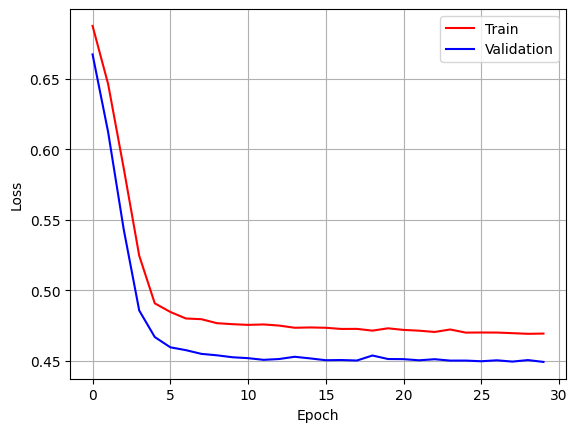

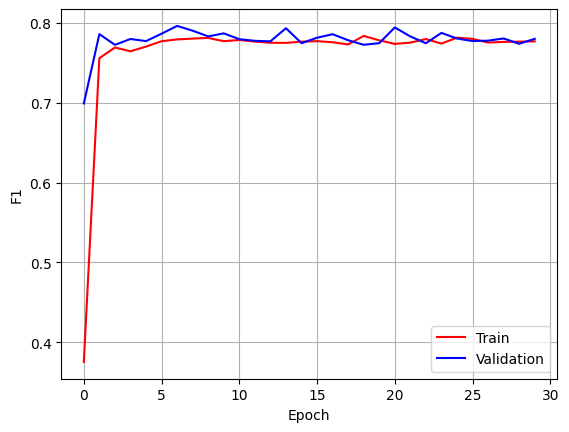

Epoch 0: 100%|██████████| 10/10 [00:01<00:00,  6.66batch/s, F1_Score=74, Loss=0.671]


Valid: Loss = 0.6438, F1_Score = 0.7461
Model Saved!



Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  6.56batch/s, F1_Score=75.3, Loss=0.614]


Valid: Loss = 0.5794, F1_Score = 0.7479
Model Saved!



Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  6.94batch/s, F1_Score=76, Loss=0.542]


Valid: Loss = 0.5145, F1_Score = 0.7634
Model Saved!



Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  7.62batch/s, F1_Score=77.2, Loss=0.496]


Valid: Loss = 0.4939, F1_Score = 0.7676
Model Saved!



Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  7.52batch/s, F1_Score=77.9, Loss=0.48]


Valid: Loss = 0.4899, F1_Score = 0.7786
Model Saved!



Epoch 5: 100%|██████████| 10/10 [00:01<00:00,  7.60batch/s, F1_Score=78.6, Loss=0.474]


Valid: Loss = 0.4879, F1_Score = 0.7696
Model Saved!



Epoch 6: 100%|██████████| 10/10 [00:01<00:00,  5.55batch/s, F1_Score=78.2, Loss=0.472]


Valid: Loss = 0.4876, F1_Score = 0.7697
Model Saved!



Epoch 7: 100%|██████████| 10/10 [00:01<00:00,  7.45batch/s, F1_Score=78.4, Loss=0.47]


Valid: Loss = 0.4876, F1_Score = 0.7667
Model Saved!



Epoch 8: 100%|██████████| 10/10 [00:01<00:00,  7.56batch/s, F1_Score=77.8, Loss=0.468]


Valid: Loss = 0.4856, F1_Score = 0.7568
Model Saved!



Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  6.50batch/s, F1_Score=78.3, Loss=0.467]


Valid: Loss = 0.4846, F1_Score = 0.7555
Model Saved!



Epoch 10: 100%|██████████| 10/10 [00:01<00:00,  6.51batch/s, F1_Score=78.1, Loss=0.466]


Valid: Loss = 0.4846, F1_Score = 0.7575



Epoch 11: 100%|██████████| 10/10 [00:01<00:00,  6.45batch/s, F1_Score=78.1, Loss=0.466]


Valid: Loss = 0.4844, F1_Score = 0.756
Model Saved!



Epoch 12: 100%|██████████| 10/10 [00:01<00:00,  7.51batch/s, F1_Score=78.3, Loss=0.465]


Valid: Loss = 0.4835, F1_Score = 0.7572
Model Saved!



Epoch 13: 100%|██████████| 10/10 [00:01<00:00,  7.66batch/s, F1_Score=78.1, Loss=0.466]


Valid: Loss = 0.4844, F1_Score = 0.7639



Epoch 14: 100%|██████████| 10/10 [00:01<00:00,  7.59batch/s, F1_Score=77.8, Loss=0.463]


Valid: Loss = 0.4852, F1_Score = 0.7733



Epoch 15: 100%|██████████| 10/10 [00:01<00:00,  7.59batch/s, F1_Score=77.8, Loss=0.464]


Valid: Loss = 0.4843, F1_Score = 0.7697



Epoch 16: 100%|██████████| 10/10 [00:01<00:00,  7.64batch/s, F1_Score=78.2, Loss=0.461]


Valid: Loss = 0.4827, F1_Score = 0.757
Model Saved!



Epoch 17: 100%|██████████| 10/10 [00:01<00:00,  7.59batch/s, F1_Score=78, Loss=0.463]


Valid: Loss = 0.4813, F1_Score = 0.7533
Model Saved!



Epoch 18: 100%|██████████| 10/10 [00:01<00:00,  7.62batch/s, F1_Score=77.9, Loss=0.463]


Valid: Loss = 0.481, F1_Score = 0.7527
Model Saved!



Epoch 19: 100%|██████████| 10/10 [00:01<00:00,  6.57batch/s, F1_Score=77.7, Loss=0.462]


Valid: Loss = 0.4855, F1_Score = 0.7683



Epoch 20: 100%|██████████| 10/10 [00:01<00:00,  6.57batch/s, F1_Score=77.8, Loss=0.464]


Valid: Loss = 0.4826, F1_Score = 0.7618



Epoch 21: 100%|██████████| 10/10 [00:01<00:00,  6.57batch/s, F1_Score=78, Loss=0.463]


Valid: Loss = 0.4798, F1_Score = 0.7544
Model Saved!



Epoch 22: 100%|██████████| 10/10 [00:01<00:00,  7.40batch/s, F1_Score=77.9, Loss=0.462]


Valid: Loss = 0.48, F1_Score = 0.7547



Epoch 23: 100%|██████████| 10/10 [00:01<00:00,  7.54batch/s, F1_Score=78, Loss=0.46]


Valid: Loss = 0.4853, F1_Score = 0.7719



Epoch 24: 100%|██████████| 10/10 [00:01<00:00,  7.58batch/s, F1_Score=77.9, Loss=0.459]


Valid: Loss = 0.4793, F1_Score = 0.7516
Model Saved!



Epoch 25: 100%|██████████| 10/10 [00:01<00:00,  7.48batch/s, F1_Score=78.2, Loss=0.459]


Valid: Loss = 0.4819, F1_Score = 0.7673



Epoch 26: 100%|██████████| 10/10 [00:01<00:00,  7.56batch/s, F1_Score=78.3, Loss=0.46]


Valid: Loss = 0.4785, F1_Score = 0.7553
Model Saved!



Epoch 27: 100%|██████████| 10/10 [00:01<00:00,  7.59batch/s, F1_Score=78, Loss=0.46]


Valid: Loss = 0.4793, F1_Score = 0.7555



Epoch 28: 100%|██████████| 10/10 [00:01<00:00,  7.56batch/s, F1_Score=78.2, Loss=0.459]


Valid: Loss = 0.4789, F1_Score = 0.7539



Epoch 29: 100%|██████████| 10/10 [00:01<00:00,  6.59batch/s, F1_Score=77.5, Loss=0.457]


Valid: Loss = 0.483, F1_Score = 0.7724



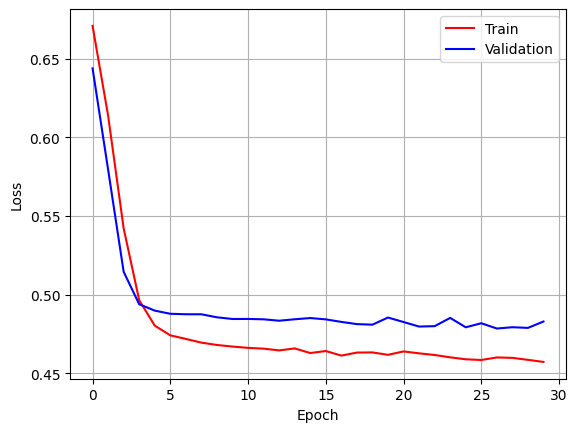

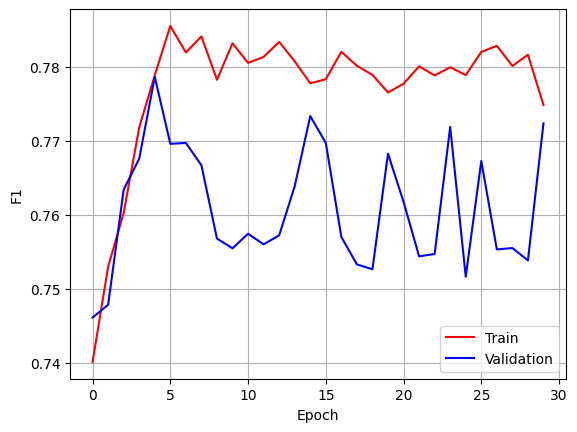

Epoch 0: 100%|██████████| 10/10 [00:01<00:00,  6.71batch/s, F1_Score=33.2, Loss=0.671]


Valid: Loss = 0.6442, F1_Score = 0.7215
Model Saved!



Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  6.53batch/s, F1_Score=72.6, Loss=0.605]


Valid: Loss = 0.5743, F1_Score = 0.7592
Model Saved!



Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  7.50batch/s, F1_Score=76.2, Loss=0.535]


Valid: Loss = 0.5215, F1_Score = 0.76
Model Saved!



Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  7.50batch/s, F1_Score=76.9, Loss=0.496]


Valid: Loss = 0.5062, F1_Score = 0.7697
Model Saved!



Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  7.44batch/s, F1_Score=78, Loss=0.484]


Valid: Loss = 0.5015, F1_Score = 0.7668
Model Saved!



Epoch 5: 100%|██████████| 10/10 [00:01<00:00,  7.45batch/s, F1_Score=78.1, Loss=0.483]


Valid: Loss = 0.4996, F1_Score = 0.7685
Model Saved!



Epoch 6: 100%|██████████| 10/10 [00:01<00:00,  7.53batch/s, F1_Score=77.8, Loss=0.48]


Valid: Loss = 0.4997, F1_Score = 0.7725



Epoch 7: 100%|██████████| 10/10 [00:01<00:00,  7.50batch/s, F1_Score=78.1, Loss=0.478]


Valid: Loss = 0.4961, F1_Score = 0.7675
Model Saved!



Epoch 8: 100%|██████████| 10/10 [00:01<00:00,  7.21batch/s, F1_Score=77.8, Loss=0.477]


Valid: Loss = 0.4986, F1_Score = 0.7747



Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  6.84batch/s, F1_Score=77.8, Loss=0.477]


Valid: Loss = 0.495, F1_Score = 0.7702
Model Saved!



Epoch 10: 100%|██████████| 10/10 [00:01<00:00,  6.48batch/s, F1_Score=77.8, Loss=0.477]


Valid: Loss = 0.4931, F1_Score = 0.7523
Model Saved!



Epoch 11: 100%|██████████| 10/10 [00:01<00:00,  6.46batch/s, F1_Score=77.9, Loss=0.476]


Valid: Loss = 0.4918, F1_Score = 0.7653
Model Saved!



Epoch 12: 100%|██████████| 10/10 [00:01<00:00,  7.52batch/s, F1_Score=77.5, Loss=0.475]


Valid: Loss = 0.4948, F1_Score = 0.775



Epoch 13: 100%|██████████| 10/10 [00:01<00:00,  7.50batch/s, F1_Score=77.8, Loss=0.474]


Valid: Loss = 0.4907, F1_Score = 0.7705
Model Saved!



Epoch 14: 100%|██████████| 10/10 [00:01<00:00,  7.49batch/s, F1_Score=78.1, Loss=0.472]


Valid: Loss = 0.4898, F1_Score = 0.7613
Model Saved!



Epoch 15: 100%|██████████| 10/10 [00:01<00:00,  7.53batch/s, F1_Score=77.7, Loss=0.472]


Valid: Loss = 0.4892, F1_Score = 0.763
Model Saved!



Epoch 16: 100%|██████████| 10/10 [00:01<00:00,  7.46batch/s, F1_Score=77.6, Loss=0.471]


Valid: Loss = 0.4902, F1_Score = 0.7703



Epoch 17: 100%|██████████| 10/10 [00:01<00:00,  7.59batch/s, F1_Score=78, Loss=0.471]


Valid: Loss = 0.4886, F1_Score = 0.7605
Model Saved!



Epoch 18: 100%|██████████| 10/10 [00:01<00:00,  7.28batch/s, F1_Score=78.3, Loss=0.471]


Valid: Loss = 0.488, F1_Score = 0.7637
Model Saved!



Epoch 19: 100%|██████████| 10/10 [00:01<00:00,  6.67batch/s, F1_Score=77.6, Loss=0.47]


Valid: Loss = 0.4882, F1_Score = 0.7713



Epoch 20: 100%|██████████| 10/10 [00:01<00:00,  6.86batch/s, F1_Score=77.7, Loss=0.47]


Valid: Loss = 0.4872, F1_Score = 0.7643
Model Saved!



Epoch 21: 100%|██████████| 10/10 [00:01<00:00,  6.44batch/s, F1_Score=78.2, Loss=0.468]


Valid: Loss = 0.4872, F1_Score = 0.76



Epoch 22: 100%|██████████| 10/10 [00:01<00:00,  7.57batch/s, F1_Score=78.1, Loss=0.47]


Valid: Loss = 0.4868, F1_Score = 0.7701
Model Saved!



Epoch 23: 100%|██████████| 10/10 [00:01<00:00,  7.42batch/s, F1_Score=77.9, Loss=0.468]


Valid: Loss = 0.4865, F1_Score = 0.7709
Model Saved!



Epoch 24: 100%|██████████| 10/10 [00:01<00:00,  7.48batch/s, F1_Score=78.3, Loss=0.467]


Valid: Loss = 0.4879, F1_Score = 0.7579



Epoch 25: 100%|██████████| 10/10 [00:01<00:00,  7.51batch/s, F1_Score=78, Loss=0.469]


Valid: Loss = 0.4866, F1_Score = 0.7702



Epoch 26: 100%|██████████| 10/10 [00:01<00:00,  7.47batch/s, F1_Score=78.2, Loss=0.467]


Valid: Loss = 0.4861, F1_Score = 0.759
Model Saved!



Epoch 27: 100%|██████████| 10/10 [00:01<00:00,  7.55batch/s, F1_Score=78.2, Loss=0.466]


Valid: Loss = 0.4854, F1_Score = 0.7701
Model Saved!



Epoch 28: 100%|██████████| 10/10 [00:01<00:00,  7.35batch/s, F1_Score=78.1, Loss=0.466]


Valid: Loss = 0.4857, F1_Score = 0.7723



Epoch 29: 100%|██████████| 10/10 [00:01<00:00,  6.31batch/s, F1_Score=78.2, Loss=0.466]


Valid: Loss = 0.4861, F1_Score = 0.7623



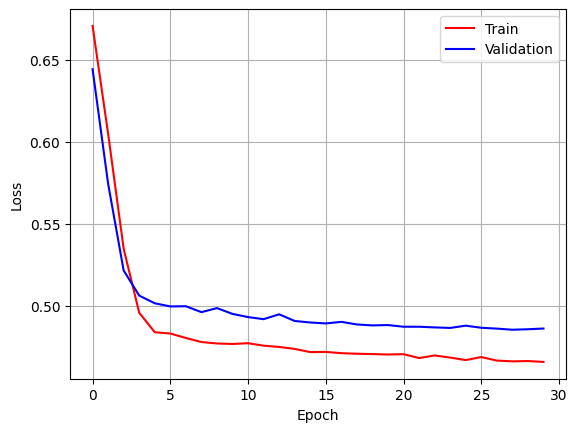

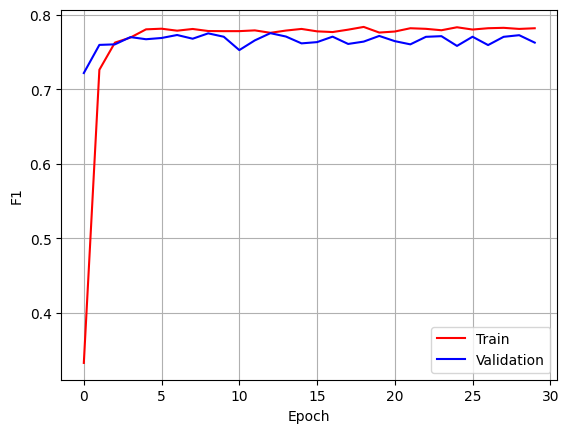

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))

metric = BinaryF1Score().to(device)
for i in range(len(bags_x) - 1):
  model = GNN(hidden_channels=32).to(device)

  lr = 0.0001
  wd = 1e-5
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
  loss_fn = nn.BCEWithLogitsLoss()

  loss_train_hist = []
  loss_valid_hist = []

  f1_train_hist = []
  f1_valid_hist = []

  best_loss_valid = torch.inf

  num_epochs = 30

  for epoch in range(num_epochs):
    # Train
    model, loss_train, f1_train = train_one_epoch(model,
                                                  train_loaders[i],
                                                  loss_fn,
                                                  optimizer,
                                                  metric,
                                                  epoch)
    # Validation
    loss_valid, f1_valid = evaluate(model,
                                    valid_loaders[i],
                                    loss_fn,
                                    metric)

    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)

    f1_train_hist.append(f1_train)
    f1_valid_hist.append(f1_valid)

    print(f'Valid: Loss = {loss_valid:.4}, F1_Score = {f1_valid:.4}')

    if loss_valid < best_loss_valid:
      torch.save(model, f'/content/drive/MyDrive/GNN{i}_fold_1.pt')
      best_loss_valid = loss_valid
      print('Model Saved!')

    print()

  plt.plot(range(num_epochs), loss_train_hist, 'r-', label='Train')
  plt.plot(range(num_epochs), loss_valid_hist, 'b-', label='Validation')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.legend()
  plt.show()

  plt.plot(range(num_epochs), f1_train_hist, 'r-', label='Train')
  plt.plot(range(num_epochs), f1_valid_hist, 'b-', label='Validation')

  plt.xlabel('Epoch')
  plt.ylabel('F1')
  plt.grid(True)
  plt.legend()
  plt.show()

## 🔴 **Test**

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def predict(model, num):
    predicted = torch.tensor([]).to(device)
    y_real = torch.tensor([]).to(device)
    with torch.no_grad():
        model.eval()
        for batch_data in test_loaders[num]:
          inputs, edge_index, batch, targets = batch_data.x, batch_data.edge_index, batch_data.batch, batch_data.y

          inputs = inputs.to(device)
          edge_index = edge_index.to(device)
          batch = batch.to(device)
          targets = targets.to(device)

          outputs = model(inputs, edge_index, batch).squeeze()

          predictions = torch.sigmoid(outputs)
          predictions[predictions <= 0.5] = 0
          predictions[predictions > 0.5] = 1
          predicted = torch.cat((predicted, predictions), dim=0)
          y_real = torch.cat((y_real, targets), dim=0)

    return predicted.squeeze(), y_real.squeeze()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, classification_report

def analysis_model(y_pred, y_test):
    acc = round(accuracy_score(y_test, y_pred), 2)
    f1 = round(f1_score(y_test, y_pred), 2)
    recall = round(recall_score(y_test, y_pred), 2)
    prec = round(precision_score(y_test, y_pred), 2)
    auc = round(roc_auc_score(y_test, y_pred), 2)
    print(f'Accuracy Score: {acc}')
    print(f'F1 Score: {f1}')
    print(f'Recall Score: {recall}')
    print(f'Precision Score: {prec}')
    print(f'ROC AUC: {auc}')

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=conf_mat)

    FPr = round((conf_mat[0][1] / (conf_mat[0][1] + conf_mat[0][0])), 2)
    FNr = round((conf_mat[1][0] / (conf_mat[1][0] + conf_mat[1][1])), 2)
    print(f'Fall-Out: {FPr}')
    print(f'Miss-Rate: {FNr}')
    print()


    # ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    fig, ax = plt.subplots(1, 2, figsize=(11, 6))
    display.plot(ax=ax[0]), ax[0].set_title('Confusion Matrix')
    ax[1].plot(fpr, tpr), ax[1].set_title('ROC AUC'), ax[1].set_xlabel('False Positive Rate'), ax[1].set_ylabel('True Positive Rate')
    plt.show()
    print(classification_report(y_test, y_pred))

    return acc, f1, recall, prec, auc, FPr, FNr

Accuracy Score: 0.77
F1 Score: 0.8
Recall Score: 0.9
Precision Score: 0.71
ROC AUC: 0.77
Fall-Out: 0.36
Miss-Rate: 0.1



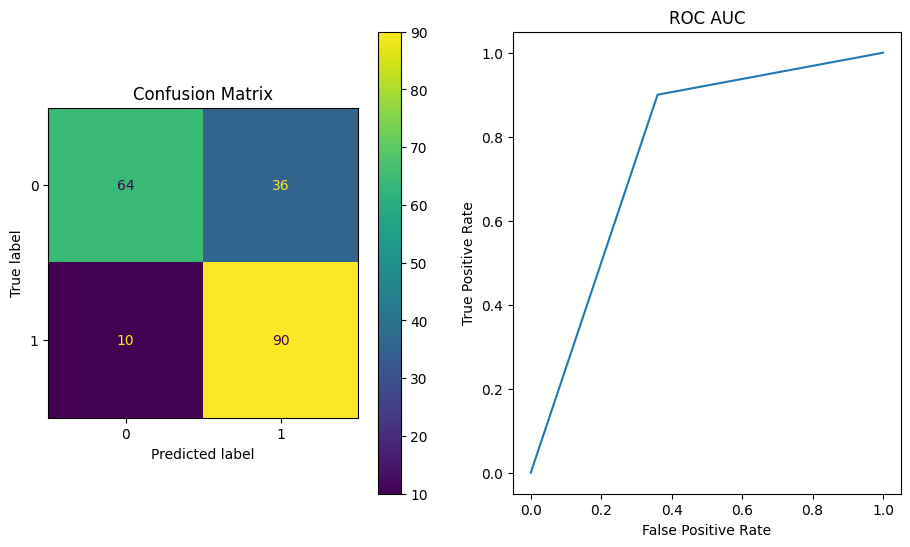

              precision    recall  f1-score   support

         0.0       0.86      0.64      0.74       100
         1.0       0.71      0.90      0.80       100

    accuracy                           0.77       200
   macro avg       0.79      0.77      0.77       200
weighted avg       0.79      0.77      0.77       200

Accuracy Score: 0.77
F1 Score: 0.79
Recall Score: 0.86
Precision Score: 0.73
ROC AUC: 0.77
Fall-Out: 0.32
Miss-Rate: 0.14



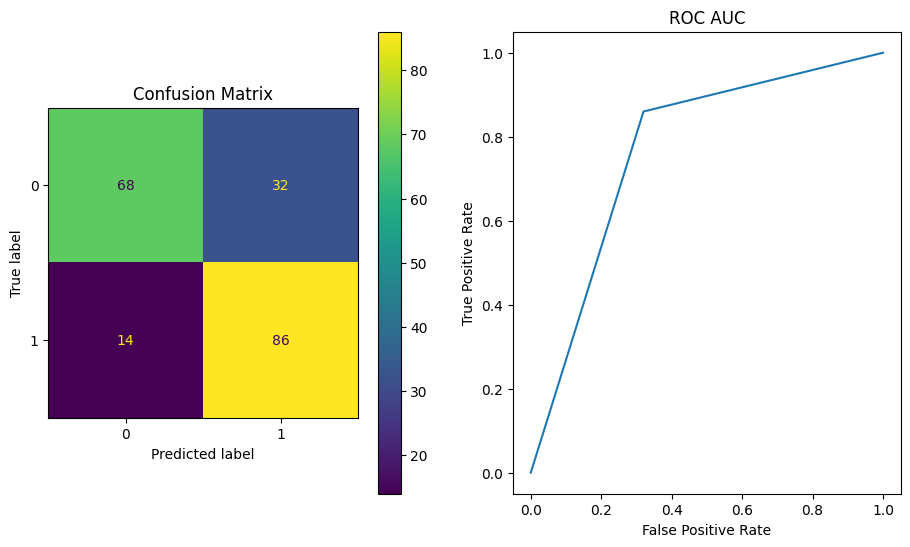

              precision    recall  f1-score   support

         0.0       0.83      0.68      0.75       100
         1.0       0.73      0.86      0.79       100

    accuracy                           0.77       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.78      0.77      0.77       200

Accuracy Score: 0.76
F1 Score: 0.79
Recall Score: 0.87
Precision Score: 0.72
ROC AUC: 0.76
Fall-Out: 0.34
Miss-Rate: 0.13



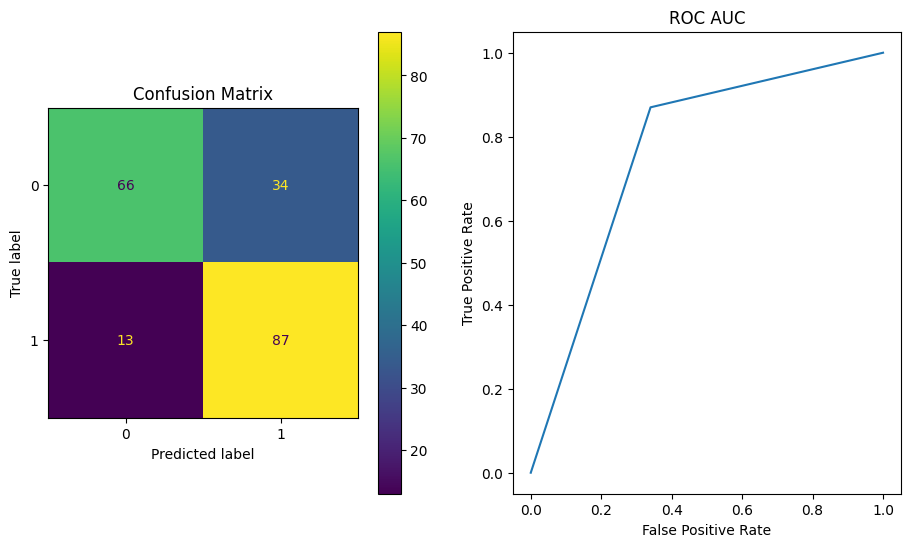

              precision    recall  f1-score   support

         0.0       0.84      0.66      0.74       100
         1.0       0.72      0.87      0.79       100

    accuracy                           0.77       200
   macro avg       0.78      0.77      0.76       200
weighted avg       0.78      0.77      0.76       200

Accuracy Score: 0.77
F1 Score: 0.79
Recall Score: 0.86
Precision Score: 0.73
ROC AUC: 0.77
Fall-Out: 0.32
Miss-Rate: 0.14



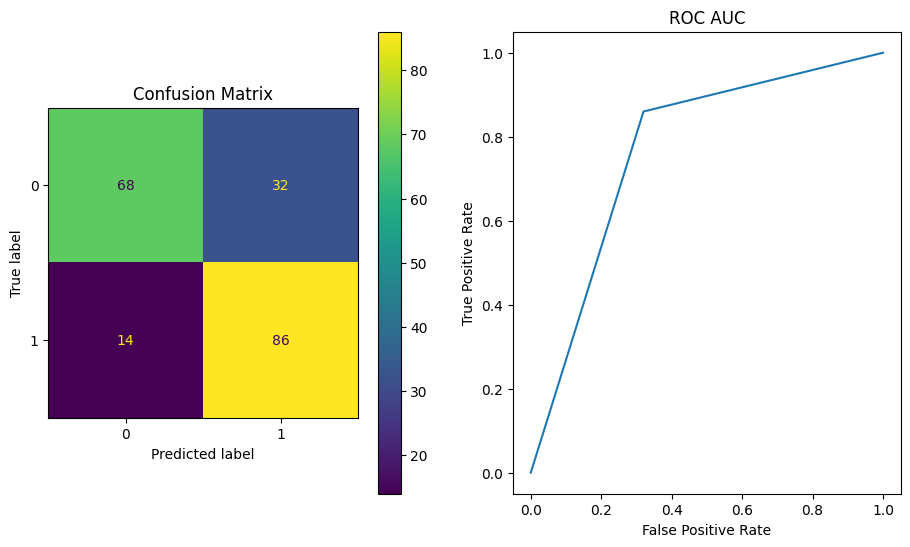

              precision    recall  f1-score   support

         0.0       0.83      0.68      0.75       100
         1.0       0.73      0.86      0.79       100

    accuracy                           0.77       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.78      0.77      0.77       200

Accuracy Score: 0.77
F1 Score: 0.79
Recall Score: 0.89
Precision Score: 0.72
ROC AUC: 0.77
Fall-Out: 0.35
Miss-Rate: 0.11



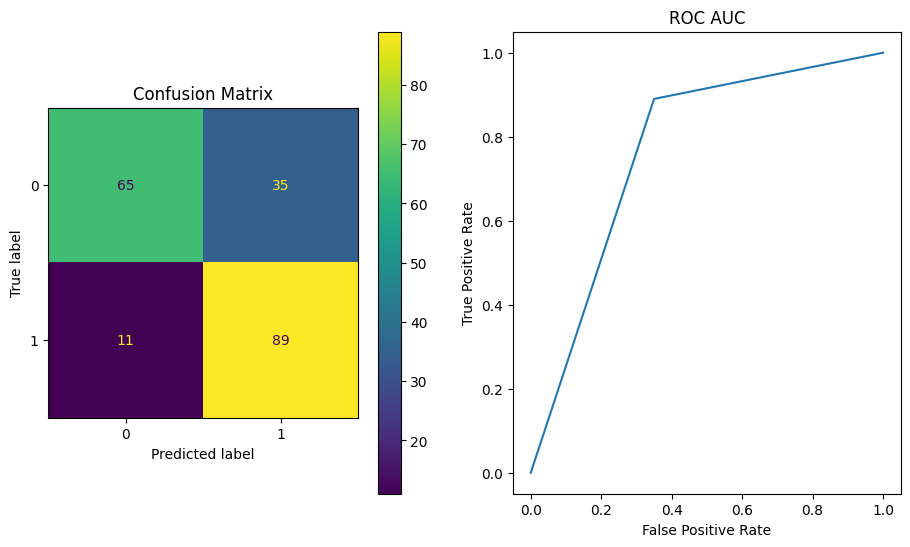

              precision    recall  f1-score   support

         0.0       0.86      0.65      0.74       100
         1.0       0.72      0.89      0.79       100

    accuracy                           0.77       200
   macro avg       0.79      0.77      0.77       200
weighted avg       0.79      0.77      0.77       200

Accuracy Score: 0.77
F1 Score: 0.79
Recall Score: 0.85
Precision Score: 0.73
ROC AUC: 0.77
Fall-Out: 0.31
Miss-Rate: 0.15



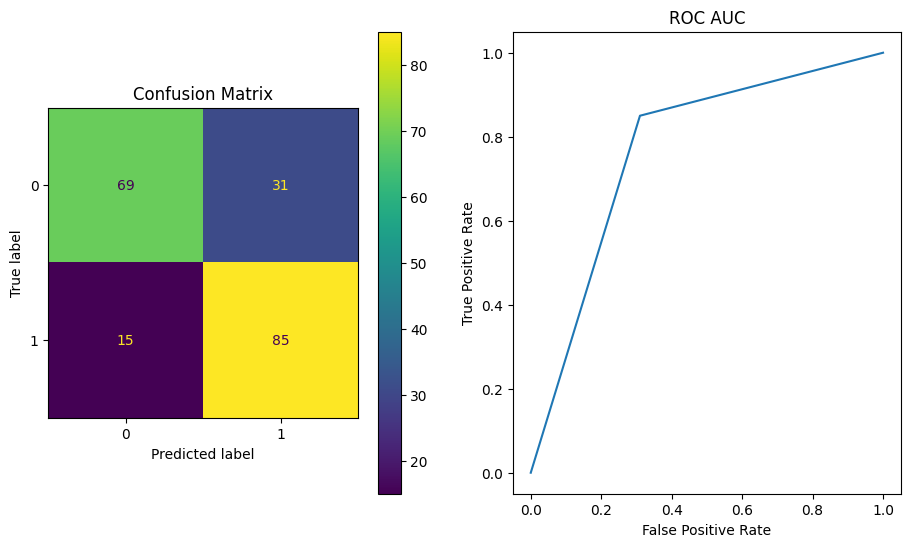

              precision    recall  f1-score   support

         0.0       0.82      0.69      0.75       100
         1.0       0.73      0.85      0.79       100

    accuracy                           0.77       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.78      0.77      0.77       200

Accuracy Score: 0.78
F1 Score: 0.79
Recall Score: 0.87
Precision Score: 0.73
ROC AUC: 0.78
Fall-Out: 0.32
Miss-Rate: 0.13



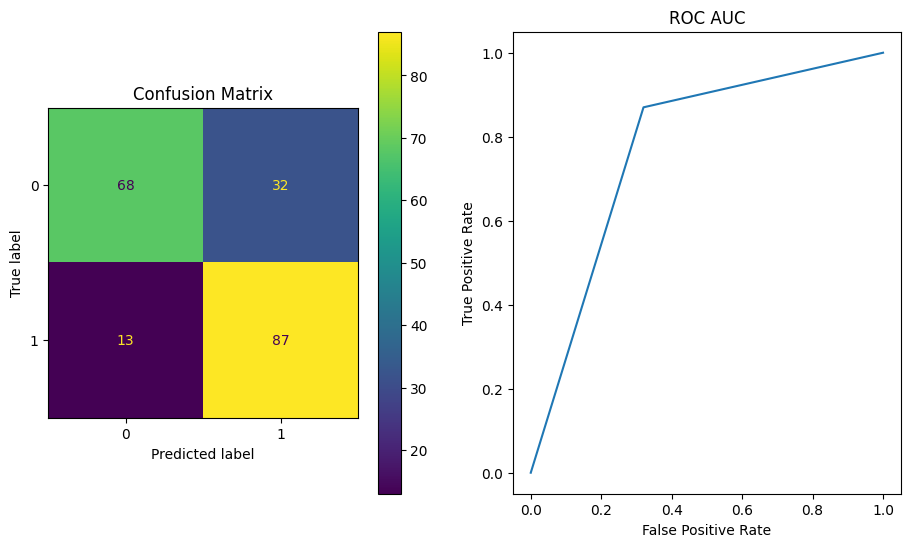

              precision    recall  f1-score   support

         0.0       0.84      0.68      0.75       100
         1.0       0.73      0.87      0.79       100

    accuracy                           0.78       200
   macro avg       0.79      0.78      0.77       200
weighted avg       0.79      0.78      0.77       200

Mean Accuracy: 0.77
Mean F1-Score: 0.79
Mean Recall: 0.87
Mean Precision: 0.72
Mean AUC: 0.77
Mean Fall-Out: 0.33
Mean Miss-Rate: 0.13


In [ ]:
accs, f1s, recalls, precs, aucs, fprs, fnrs = [], [], [], [], [], [], []
for i in range(len(bags_x) - 1):
  model = torch.load(f'/content/drive/MyDrive/GNN{i}_fold_1.pt').to(device)
  prediction, y_real = predict(model, i)
  acc, f1, recall, prec, auc, fpr, fnr = analysis_model(prediction.cpu().detach().numpy(), y_real.cpu().detach().numpy())
  accs.append(acc)
  f1s.append(f1)
  recalls.append(recall)
  precs.append(prec)
  aucs.append(auc)
  fprs.append(fpr)
  fnrs.append(fnr)

print(f'Mean Accuracy: {round(sum(accs) / len(accs), 2)}')
print(f'Mean F1-Score: {round(sum(f1s) / len(f1s), 2)}')
print(f'Mean Recall: {round(sum(recalls) / len(recalls), 2)}')
print(f'Mean Precision: {round(sum(precs) / len(precs), 2)}')
print(f'Mean AUC: {round(sum(aucs) / len(aucs), 2)}')
print(f'Mean Fall-Out: {round(sum(fprs) / len(fprs), 2)}')
print(f'Mean Miss-Rate: {round(sum(fnrs) / len(fnrs), 2)}')

Accuracy Score: 0.8
F1 Score: 0.81
Recall Score: 0.84
Precision Score: 0.78
ROC AUC: 0.8
Fall-Out: 0.24
Miss-Rate: 0.16



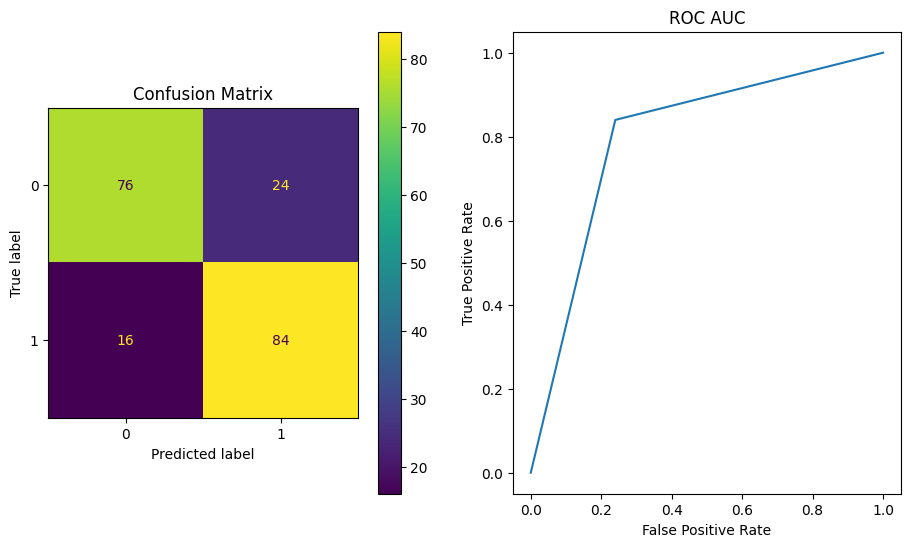

              precision    recall  f1-score   support

         0.0       0.83      0.76      0.79       100
         1.0       0.78      0.84      0.81       100

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200

Accuracy Score: 0.8
F1 Score: 0.82
Recall Score: 0.87
Precision Score: 0.77
ROC AUC: 0.8
Fall-Out: 0.26
Miss-Rate: 0.13



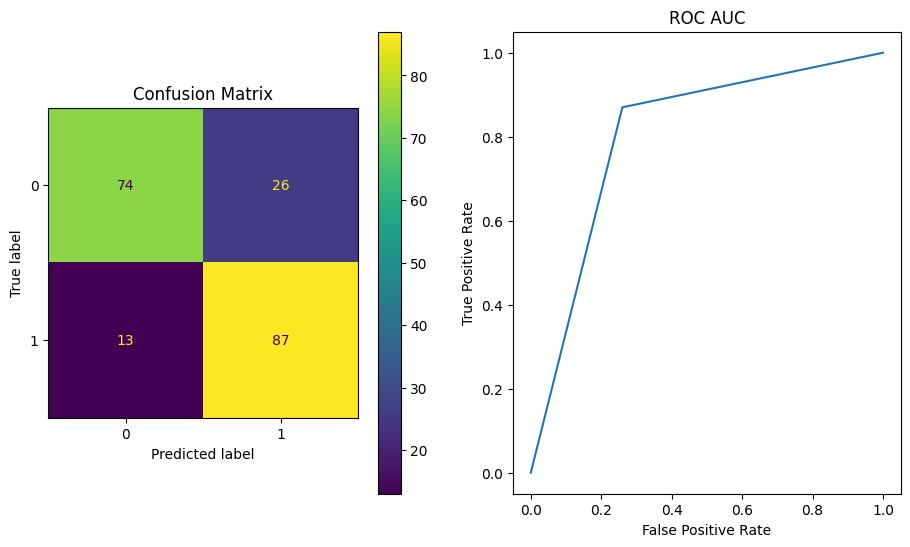

              precision    recall  f1-score   support

         0.0       0.85      0.74      0.79       100
         1.0       0.77      0.87      0.82       100

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200

Accuracy Score: 0.78
F1 Score: 0.8
Recall Score: 0.86
Precision Score: 0.75
ROC AUC: 0.78
Fall-Out: 0.29
Miss-Rate: 0.14



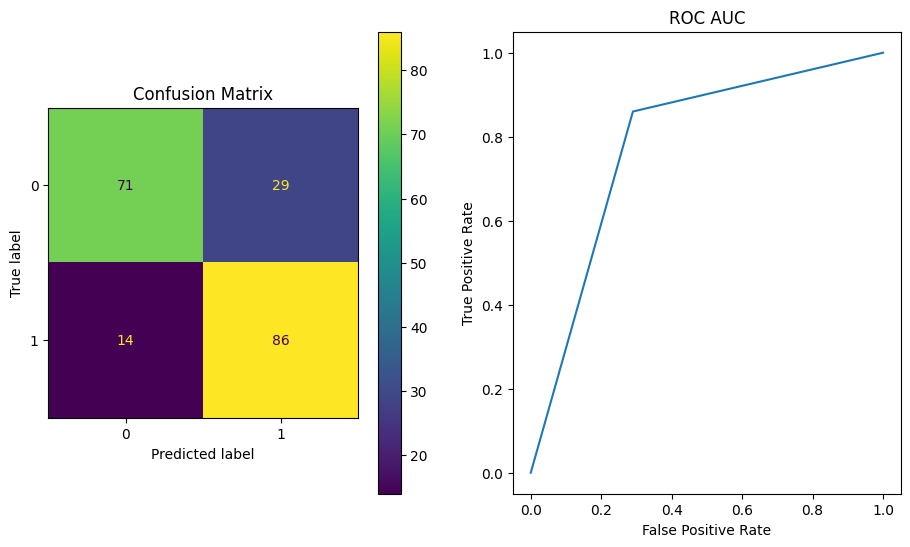

              precision    recall  f1-score   support

         0.0       0.84      0.71      0.77       100
         1.0       0.75      0.86      0.80       100

    accuracy                           0.79       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.79      0.79      0.78       200

Accuracy Score: 0.81
F1 Score: 0.82
Recall Score: 0.89
Precision Score: 0.77
ROC AUC: 0.81
Fall-Out: 0.27
Miss-Rate: 0.11



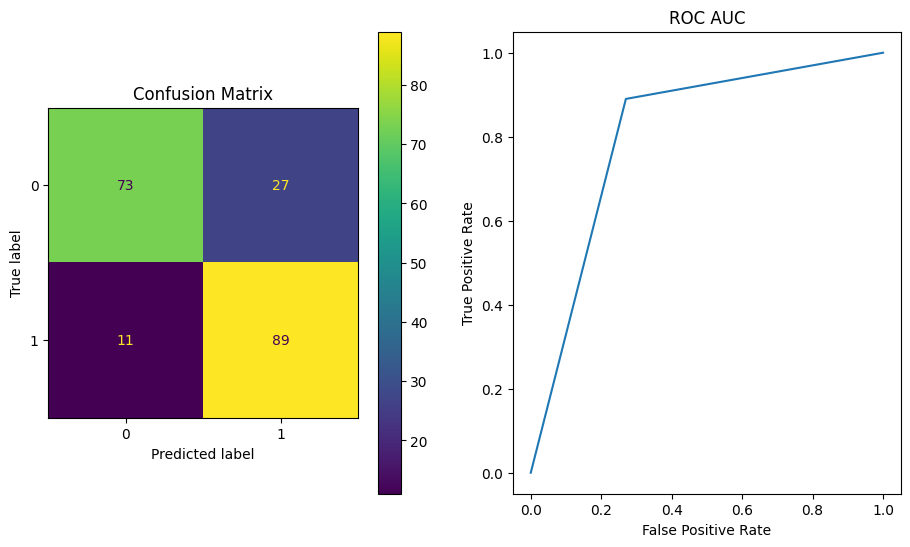

              precision    recall  f1-score   support

         0.0       0.87      0.73      0.79       100
         1.0       0.77      0.89      0.82       100

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200

Accuracy Score: 0.8
F1 Score: 0.81
Recall Score: 0.88
Precision Score: 0.75
ROC AUC: 0.8
Fall-Out: 0.29
Miss-Rate: 0.12



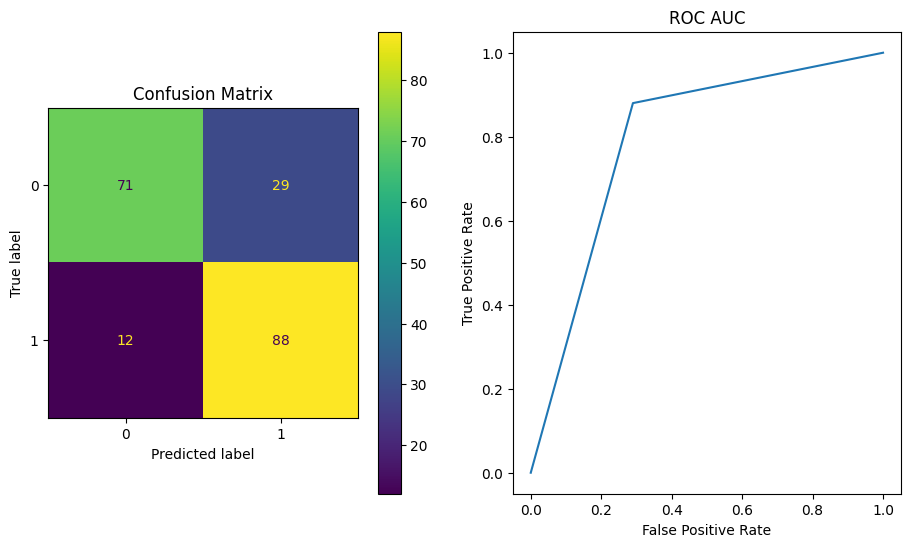

              precision    recall  f1-score   support

         0.0       0.86      0.71      0.78       100
         1.0       0.75      0.88      0.81       100

    accuracy                           0.80       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.80      0.80      0.79       200

Accuracy Score: 0.8
F1 Score: 0.81
Recall Score: 0.87
Precision Score: 0.76
ROC AUC: 0.8
Fall-Out: 0.27
Miss-Rate: 0.13



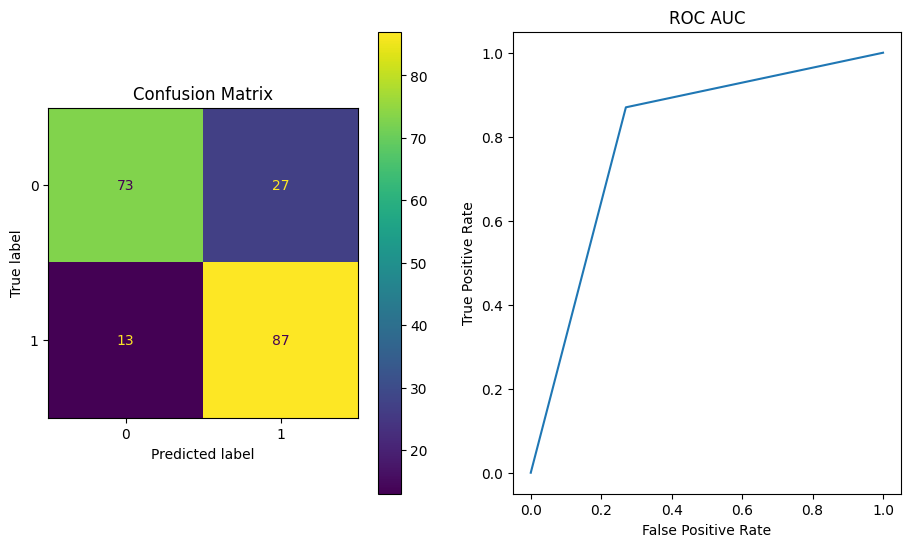

              precision    recall  f1-score   support

         0.0       0.85      0.73      0.78       100
         1.0       0.76      0.87      0.81       100

    accuracy                           0.80       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.80      0.80       200

Accuracy Score: 0.81
F1 Score: 0.82
Recall Score: 0.85
Precision Score: 0.79
ROC AUC: 0.81
Fall-Out: 0.23
Miss-Rate: 0.15



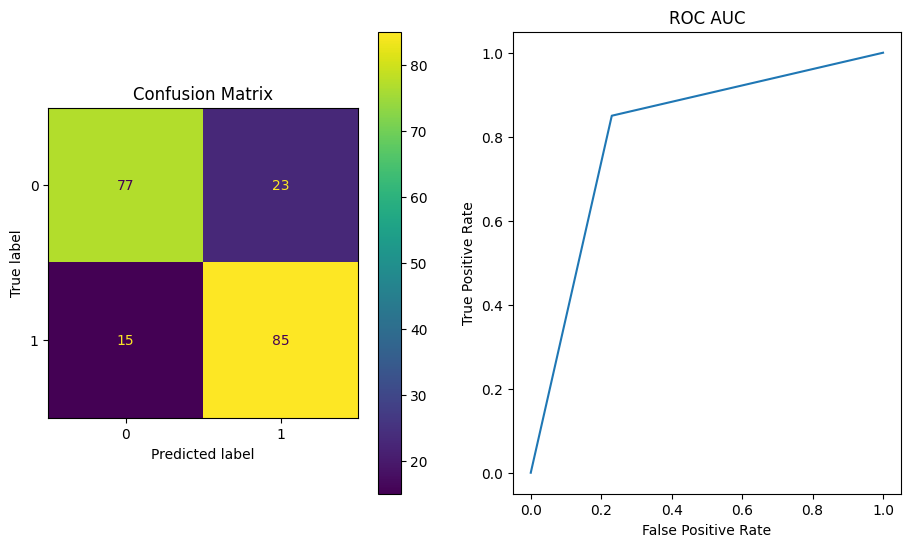

              precision    recall  f1-score   support

         0.0       0.84      0.77      0.80       100
         1.0       0.79      0.85      0.82       100

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200

Mean Accuracy: 0.8
Mean F1-Score: 0.81
Mean Recall: 0.87
Mean Precision: 0.77
Mean AUC: 0.8
Mean Fall-Out: 0.26
Mean Miss-Rate: 0.13


In [ ]:
accs, f1s, recalls, precs, aucs, fprs, fnrs = [], [], [], [], [], [], []
for i in range(len(bags_x) - 1):
  model = torch.load(f'/content/drive/MyDrive/GNN{i}_fold_2.pt').to(device)
  prediction, y_real = predict(model, i)
  acc, f1, recall, prec, auc, fpr, fnr = analysis_model(prediction.cpu().detach().numpy(), y_real.cpu().detach().numpy())
  accs.append(acc)
  f1s.append(f1)
  recalls.append(recall)
  precs.append(prec)
  aucs.append(auc)
  fprs.append(fpr)
  fnrs.append(fnr)

print(f'Mean Accuracy: {round(sum(accs) / len(accs), 2)}')
print(f'Mean F1-Score: {round(sum(f1s) / len(f1s), 2)}')
print(f'Mean Recall: {round(sum(recalls) / len(recalls), 2)}')
print(f'Mean Precision: {round(sum(precs) / len(precs), 2)}')
print(f'Mean AUC: {round(sum(aucs) / len(aucs), 2)}')
print(f'Mean Fall-Out: {round(sum(fprs) / len(fprs), 2)}')
print(f'Mean Miss-Rate: {round(sum(fnrs) / len(fnrs), 2)}')

Accuracy Score: 0.81
F1 Score: 0.82
Recall Score: 0.88
Precision Score: 0.77
ROC AUC: 0.81
Fall-Out: 0.26
Miss-Rate: 0.12



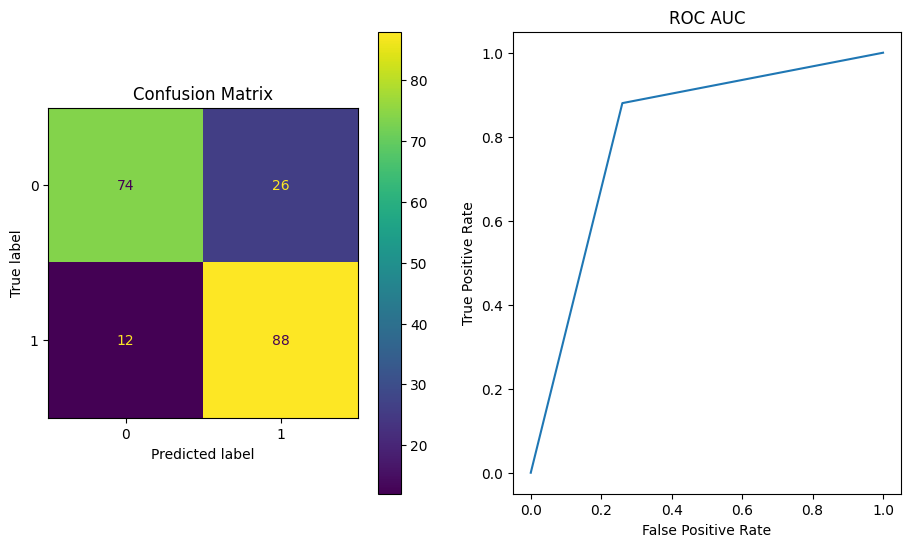

              precision    recall  f1-score   support

         0.0       0.86      0.74      0.80       100
         1.0       0.77      0.88      0.82       100

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200

Accuracy Score: 0.81
F1 Score: 0.82
Recall Score: 0.86
Precision Score: 0.78
ROC AUC: 0.81
Fall-Out: 0.24
Miss-Rate: 0.14



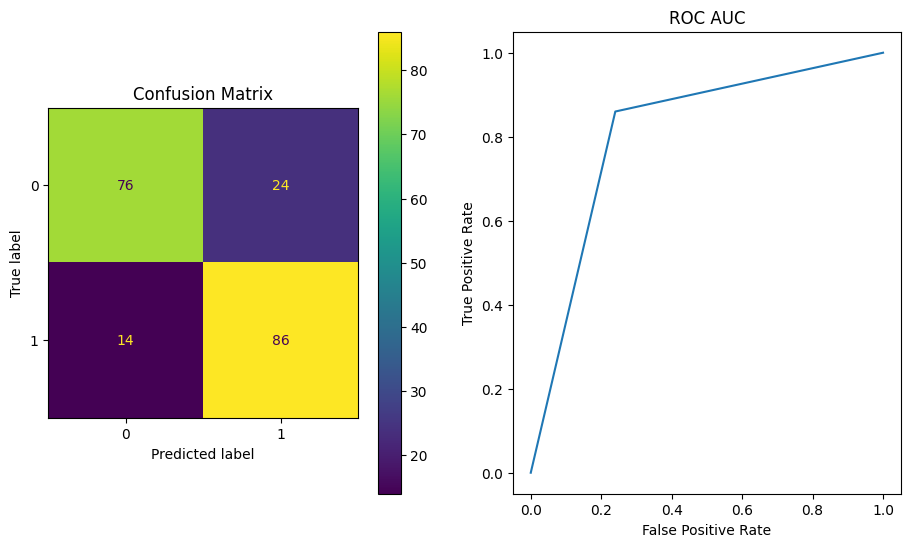

              precision    recall  f1-score   support

         0.0       0.84      0.76      0.80       100
         1.0       0.78      0.86      0.82       100

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200

Accuracy Score: 0.8
F1 Score: 0.82
Recall Score: 0.87
Precision Score: 0.77
ROC AUC: 0.8
Fall-Out: 0.26
Miss-Rate: 0.13



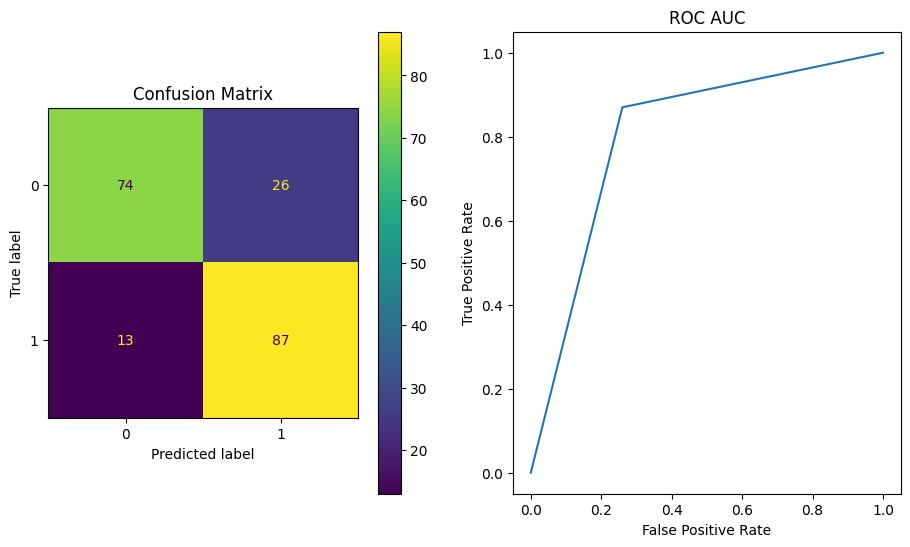

              precision    recall  f1-score   support

         0.0       0.85      0.74      0.79       100
         1.0       0.77      0.87      0.82       100

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200

Accuracy Score: 0.82
F1 Score: 0.83
Recall Score: 0.89
Precision Score: 0.77
ROC AUC: 0.82
Fall-Out: 0.26
Miss-Rate: 0.11



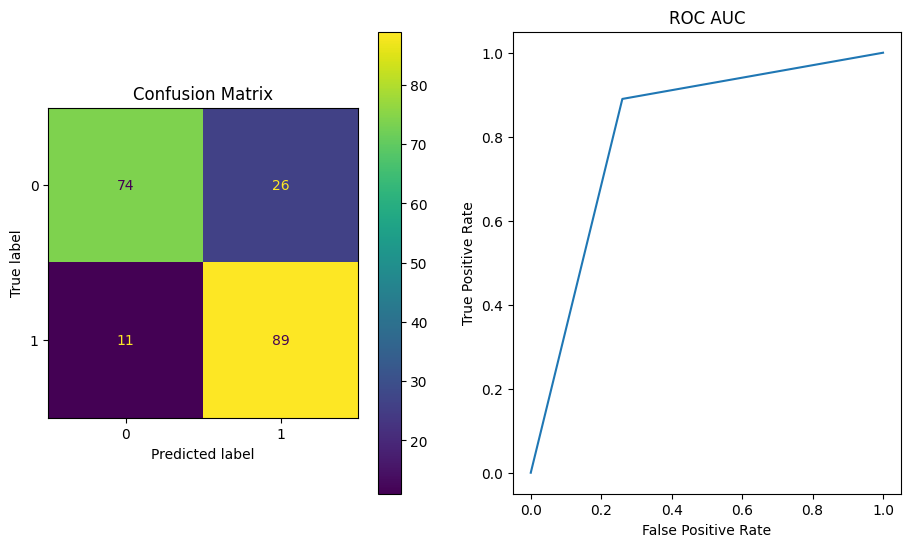

              precision    recall  f1-score   support

         0.0       0.87      0.74      0.80       100
         1.0       0.77      0.89      0.83       100

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200

Accuracy Score: 0.8
F1 Score: 0.82
Recall Score: 0.87
Precision Score: 0.77
ROC AUC: 0.8
Fall-Out: 0.26
Miss-Rate: 0.13



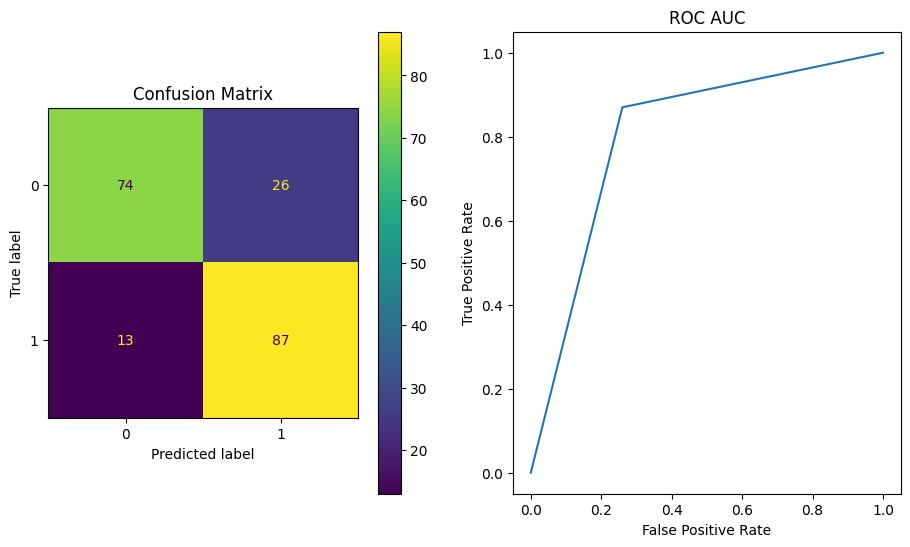

              precision    recall  f1-score   support

         0.0       0.85      0.74      0.79       100
         1.0       0.77      0.87      0.82       100

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200

Accuracy Score: 0.8
F1 Score: 0.81
Recall Score: 0.88
Precision Score: 0.76
ROC AUC: 0.8
Fall-Out: 0.28
Miss-Rate: 0.12



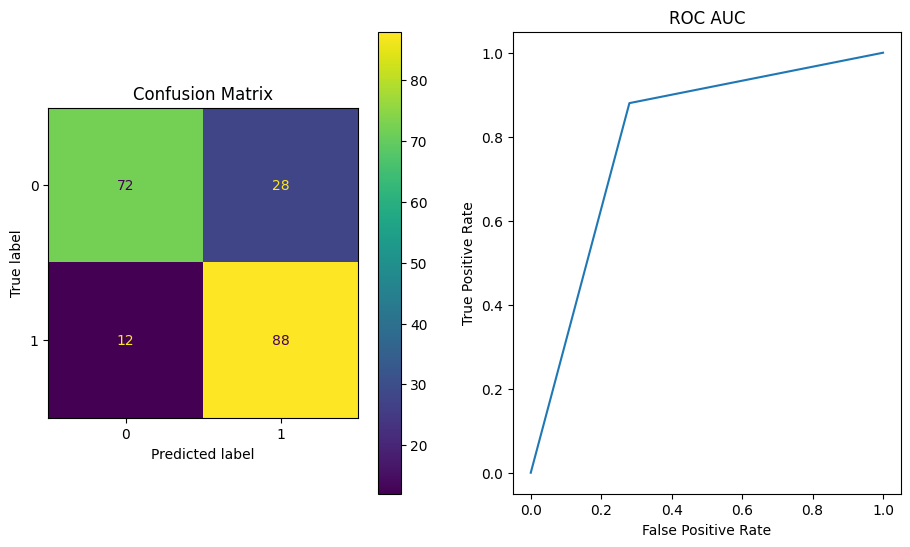

              precision    recall  f1-score   support

         0.0       0.86      0.72      0.78       100
         1.0       0.76      0.88      0.81       100

    accuracy                           0.80       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.80      0.80       200

Accuracy Score: 0.82
F1 Score: 0.83
Recall Score: 0.87
Precision Score: 0.79
ROC AUC: 0.82
Fall-Out: 0.23
Miss-Rate: 0.13



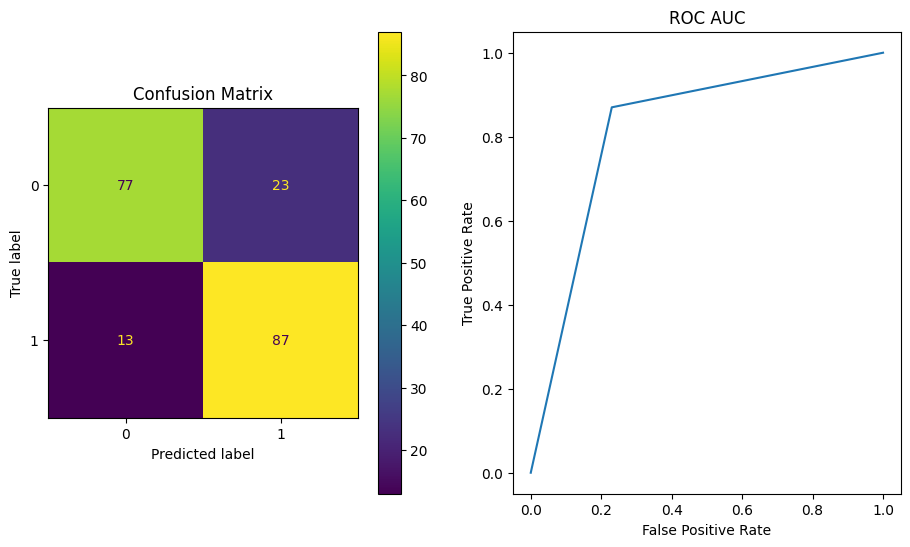

              precision    recall  f1-score   support

         0.0       0.86      0.77      0.81       100
         1.0       0.79      0.87      0.83       100

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200

Mean Accuracy: 0.81
Mean F1-Score: 0.82
Mean Recall: 0.87
Mean Precision: 0.77
Mean AUC: 0.81
Mean Fall-Out: 0.26
Mean Miss-Rate: 0.13


In [ ]:
accs, f1s, recalls, precs, aucs, fprs, fnrs = [], [], [], [], [], [], []
for i in range(len(bags_x) - 1):
  model = torch.load(f'/content/drive/MyDrive/GNN{i}_fold_3.pt').to(device)
  prediction, y_real = predict(model, i)
  acc, f1, recall, prec, auc, fpr, fnr = analysis_model(prediction.cpu().detach().numpy(), y_real.cpu().detach().numpy())
  accs.append(acc)
  f1s.append(f1)
  recalls.append(recall)
  precs.append(prec)
  aucs.append(auc)
  fprs.append(fpr)
  fnrs.append(fnr)

print(f'Mean Accuracy: {round(sum(accs) / len(accs), 2)}')
print(f'Mean F1-Score: {round(sum(f1s) / len(f1s), 2)}')
print(f'Mean Recall: {round(sum(recalls) / len(recalls), 2)}')
print(f'Mean Precision: {round(sum(precs) / len(precs), 2)}')
print(f'Mean AUC: {round(sum(aucs) / len(aucs), 2)}')
print(f'Mean Fall-Out: {round(sum(fprs) / len(fprs), 2)}')
print(f'Mean Miss-Rate: {round(sum(fnrs) / len(fnrs), 2)}')

Accuracy Score: 0.8
F1 Score: 0.81
Recall Score: 0.85
Precision Score: 0.78
ROC AUC: 0.8
Fall-Out: 0.24
Miss-Rate: 0.15



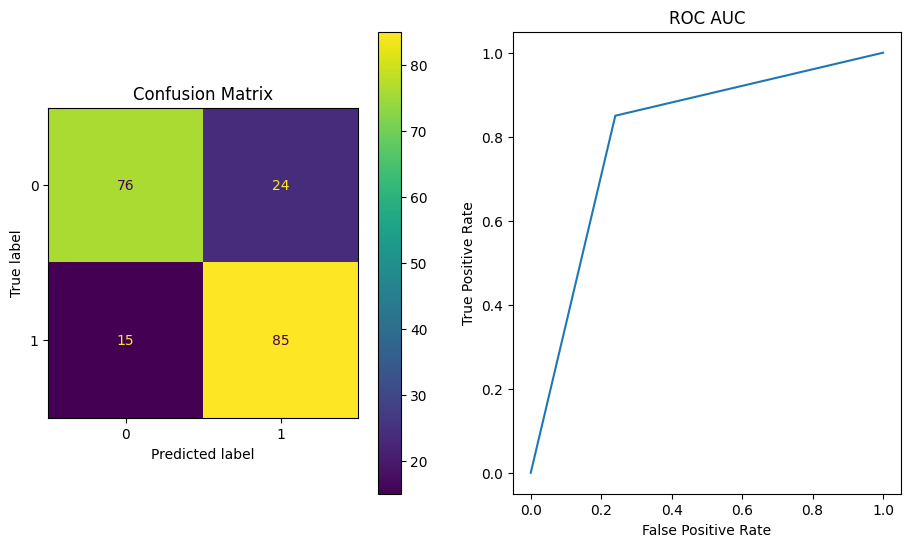

              precision    recall  f1-score   support

         0.0       0.84      0.76      0.80       100
         1.0       0.78      0.85      0.81       100

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200

Accuracy Score: 0.8
F1 Score: 0.81
Recall Score: 0.84
Precision Score: 0.79
ROC AUC: 0.8
Fall-Out: 0.23
Miss-Rate: 0.16



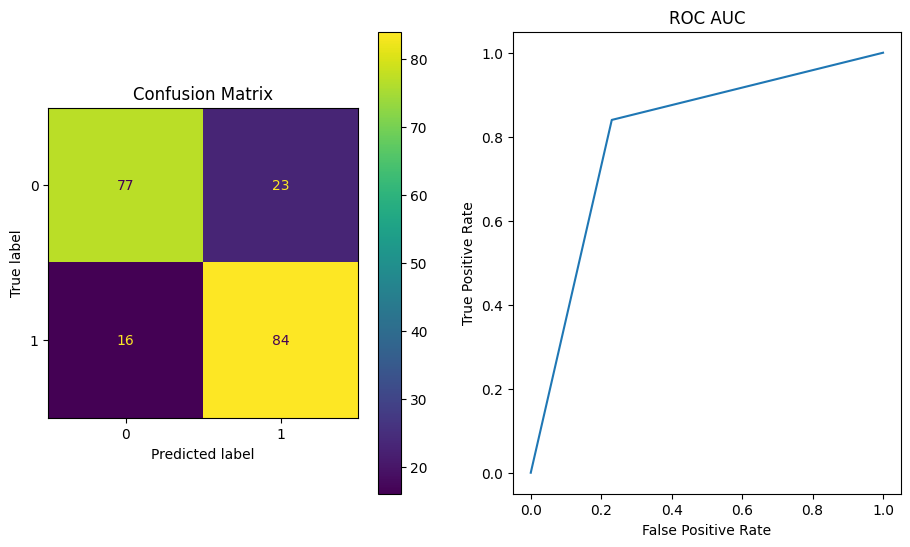

              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80       100
         1.0       0.79      0.84      0.81       100

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200

Accuracy Score: 0.81
F1 Score: 0.82
Recall Score: 0.84
Precision Score: 0.79
ROC AUC: 0.81
Fall-Out: 0.22
Miss-Rate: 0.16



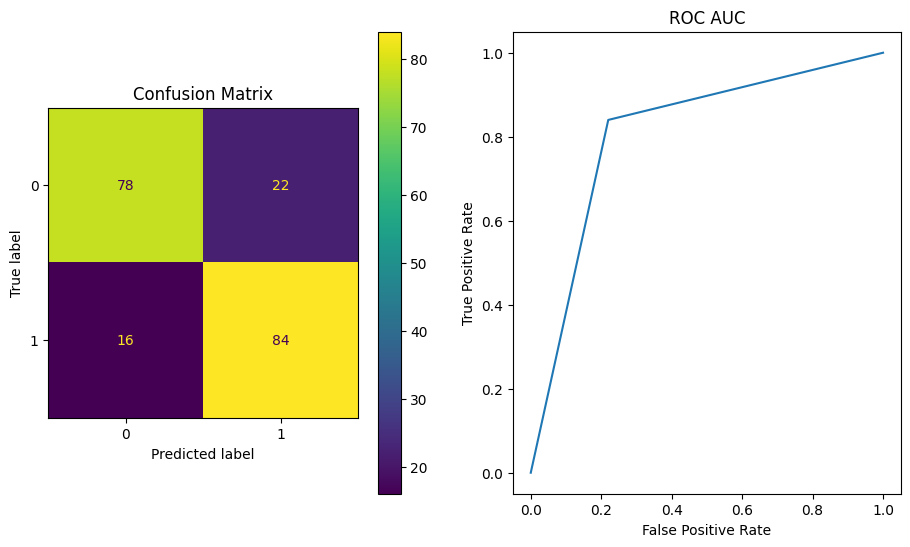

              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80       100
         1.0       0.79      0.84      0.82       100

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200

Accuracy Score: 0.81
F1 Score: 0.81
Recall Score: 0.83
Precision Score: 0.8
ROC AUC: 0.81
Fall-Out: 0.21
Miss-Rate: 0.17



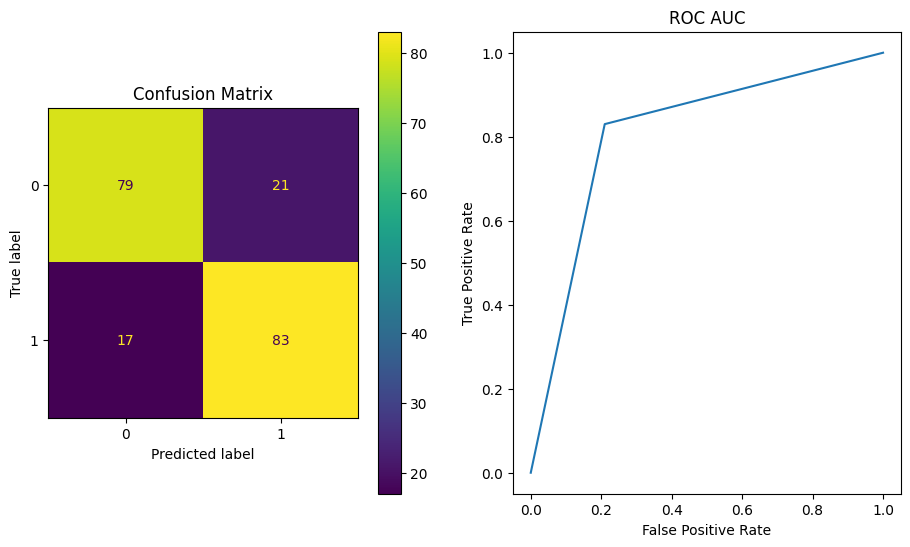

              precision    recall  f1-score   support

         0.0       0.82      0.79      0.81       100
         1.0       0.80      0.83      0.81       100

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200

Accuracy Score: 0.8
F1 Score: 0.81
Recall Score: 0.83
Precision Score: 0.78
ROC AUC: 0.8
Fall-Out: 0.23
Miss-Rate: 0.17



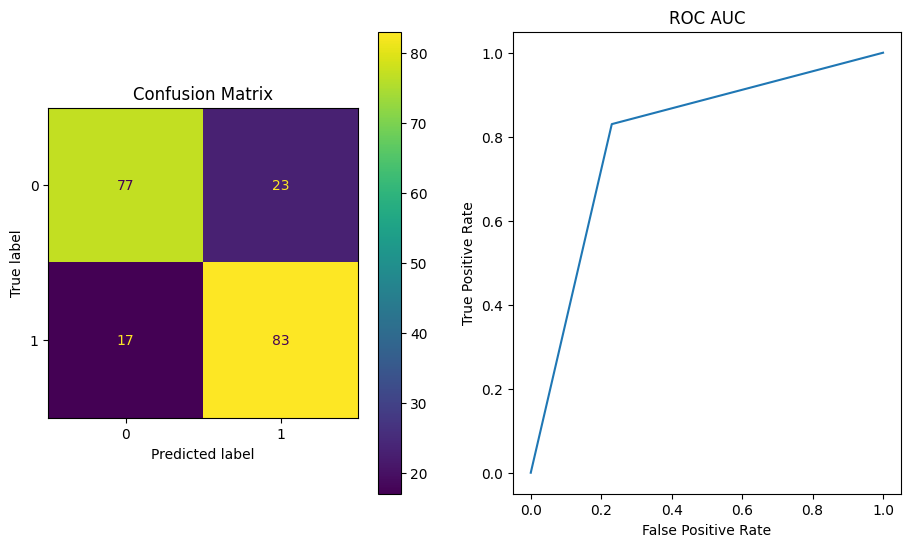

              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79       100
         1.0       0.78      0.83      0.81       100

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200

Accuracy Score: 0.81
F1 Score: 0.82
Recall Score: 0.84
Precision Score: 0.79
ROC AUC: 0.81
Fall-Out: 0.22
Miss-Rate: 0.16



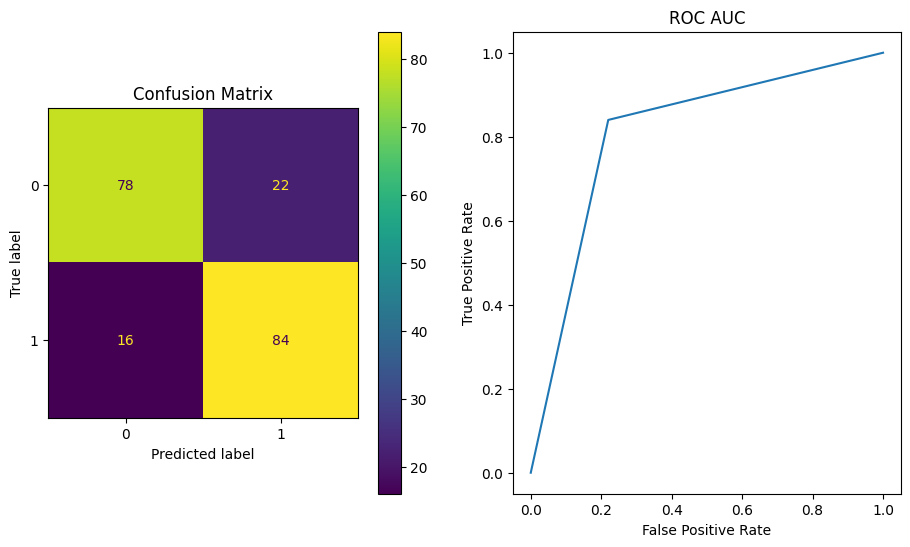

              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80       100
         1.0       0.79      0.84      0.82       100

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200

Accuracy Score: 0.8
F1 Score: 0.81
Recall Score: 0.83
Precision Score: 0.78
ROC AUC: 0.8
Fall-Out: 0.23
Miss-Rate: 0.17



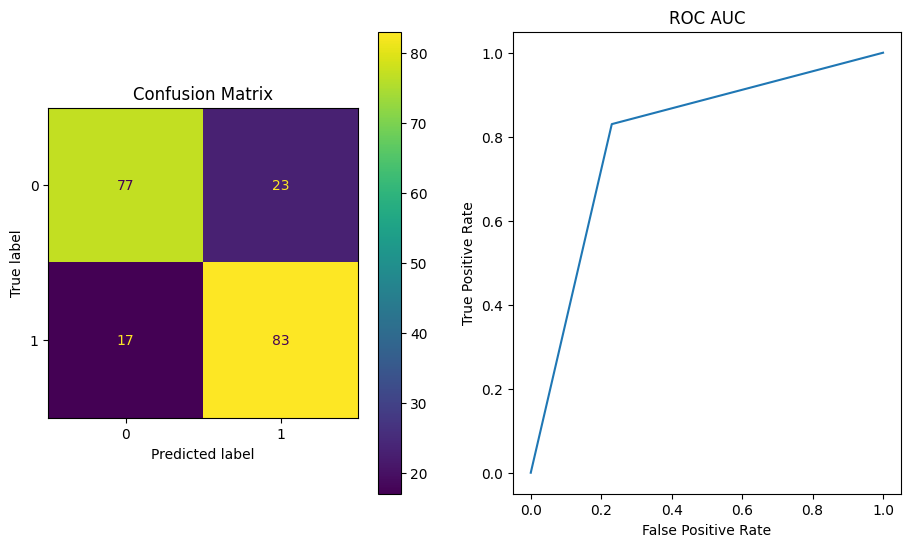

              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79       100
         1.0       0.78      0.83      0.81       100

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200

Mean Accuracy: 0.8
Mean F1-Score: 0.81
Mean Recall: 0.84
Mean Precision: 0.79
Mean AUC: 0.8
Mean Fall-Out: 0.23
Mean Miss-Rate: 0.16


In [ ]:
accs, f1s, recalls, precs, aucs, fprs, fnrs = [], [], [], [], [], [], []
for i in range(len(bags_x) - 1):
  model = torch.load(f'/content/drive/MyDrive/GNN{i}_fold_4.pt').to(device)
  prediction, y_real = predict(model, i)
  acc, f1, recall, prec, auc, fpr, fnr = analysis_model(prediction.cpu().detach().numpy(), y_real.cpu().detach().numpy())
  accs.append(acc)
  f1s.append(f1)
  recalls.append(recall)
  precs.append(prec)
  aucs.append(auc)
  fprs.append(fpr)
  fnrs.append(fnr)

print(f'Mean Accuracy: {round(sum(accs) / len(accs), 2)}')
print(f'Mean F1-Score: {round(sum(f1s) / len(f1s), 2)}')
print(f'Mean Recall: {round(sum(recalls) / len(recalls), 2)}')
print(f'Mean Precision: {round(sum(precs) / len(precs), 2)}')
print(f'Mean AUC: {round(sum(aucs) / len(aucs), 2)}')
print(f'Mean Fall-Out: {round(sum(fprs) / len(fprs), 2)}')
print(f'Mean Miss-Rate: {round(sum(fnrs) / len(fnrs), 2)}')

Accuracy Score: 0.82
F1 Score: 0.83
Recall Score: 0.86
Precision Score: 0.8
ROC AUC: 0.82
Fall-Out: 0.21
Miss-Rate: 0.14



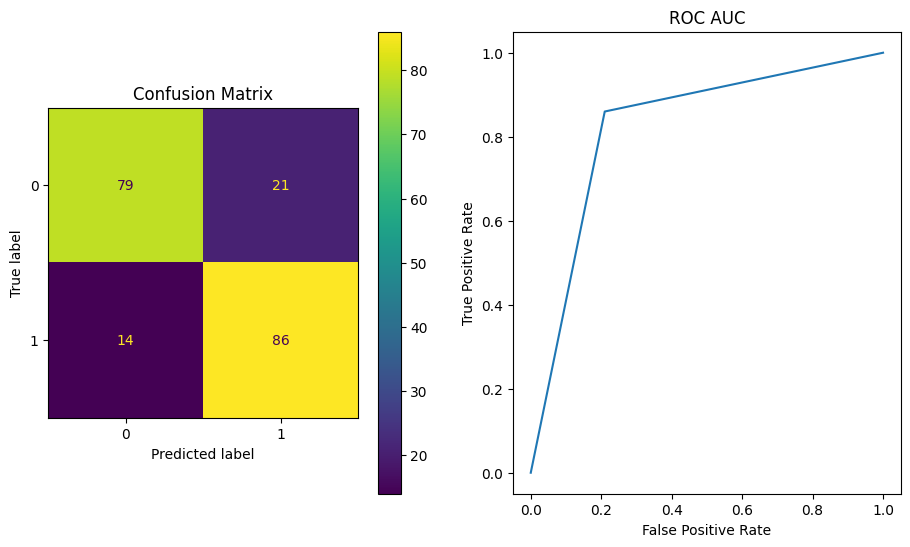

              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82       100
         1.0       0.80      0.86      0.83       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200

Accuracy Score: 0.82
F1 Score: 0.83
Recall Score: 0.86
Precision Score: 0.8
ROC AUC: 0.82
Fall-Out: 0.22
Miss-Rate: 0.14



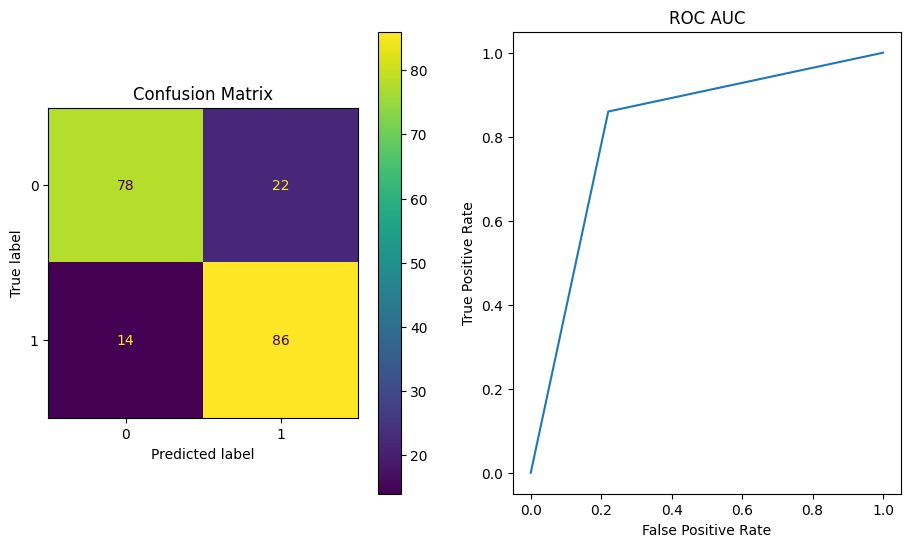

              precision    recall  f1-score   support

         0.0       0.85      0.78      0.81       100
         1.0       0.80      0.86      0.83       100

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200

Accuracy Score: 0.82
F1 Score: 0.83
Recall Score: 0.86
Precision Score: 0.8
ROC AUC: 0.82
Fall-Out: 0.21
Miss-Rate: 0.14



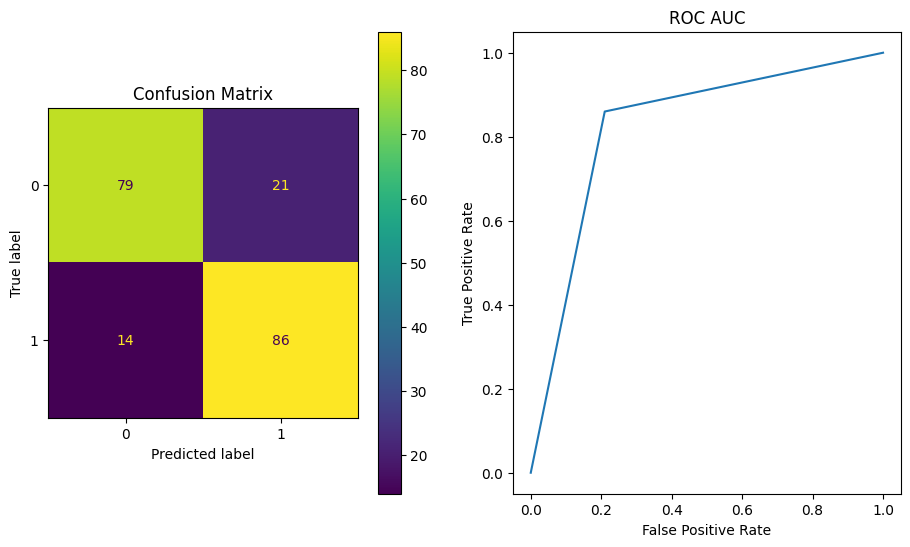

              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82       100
         1.0       0.80      0.86      0.83       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200

Accuracy Score: 0.82
F1 Score: 0.83
Recall Score: 0.87
Precision Score: 0.79
ROC AUC: 0.82
Fall-Out: 0.23
Miss-Rate: 0.13



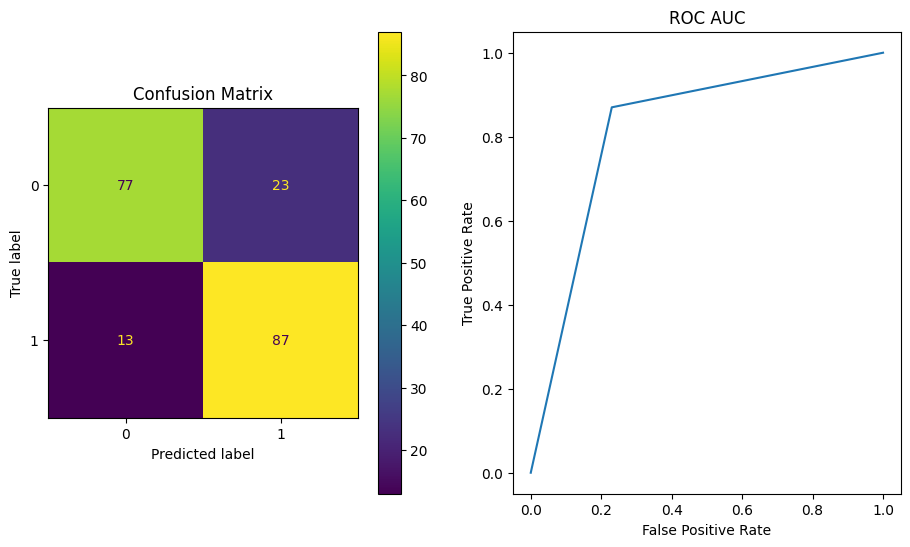

              precision    recall  f1-score   support

         0.0       0.86      0.77      0.81       100
         1.0       0.79      0.87      0.83       100

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200

Accuracy Score: 0.82
F1 Score: 0.83
Recall Score: 0.87
Precision Score: 0.8
ROC AUC: 0.82
Fall-Out: 0.22
Miss-Rate: 0.13



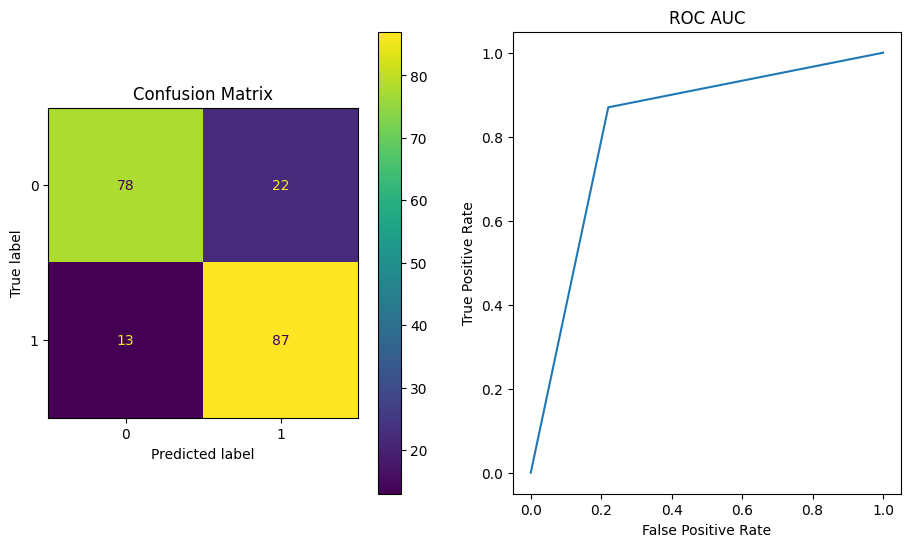

              precision    recall  f1-score   support

         0.0       0.86      0.78      0.82       100
         1.0       0.80      0.87      0.83       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200

Accuracy Score: 0.81
F1 Score: 0.82
Recall Score: 0.87
Precision Score: 0.78
ROC AUC: 0.81
Fall-Out: 0.25
Miss-Rate: 0.13



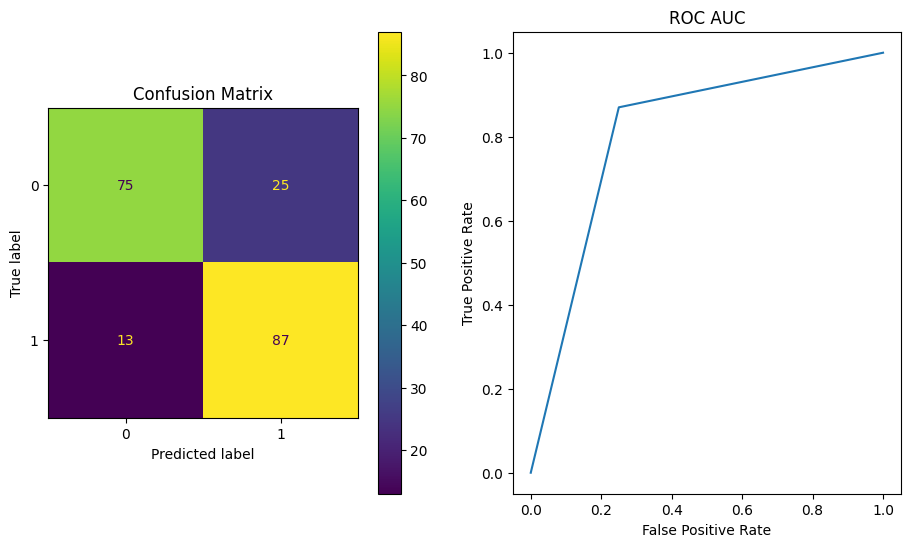

              precision    recall  f1-score   support

         0.0       0.85      0.75      0.80       100
         1.0       0.78      0.87      0.82       100

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200

Accuracy Score: 0.82
F1 Score: 0.83
Recall Score: 0.87
Precision Score: 0.8
ROC AUC: 0.82
Fall-Out: 0.22
Miss-Rate: 0.13



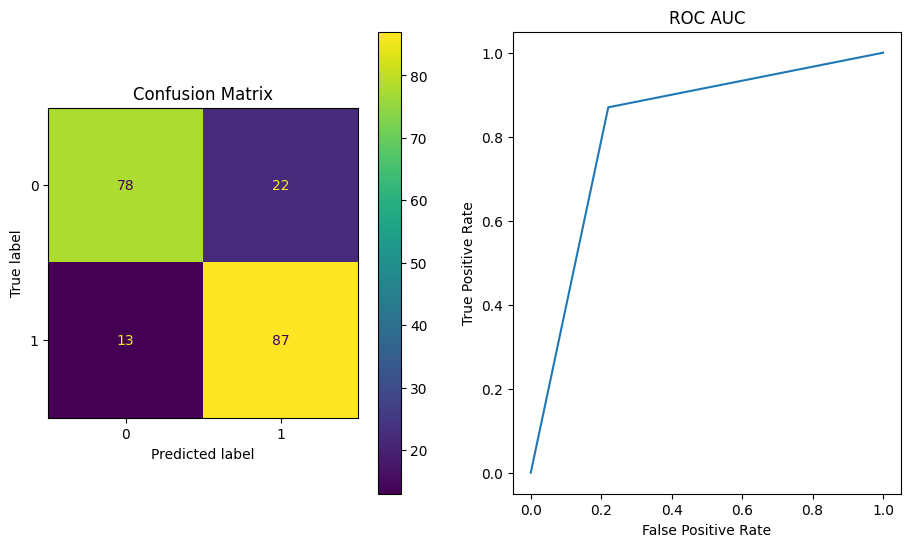

              precision    recall  f1-score   support

         0.0       0.86      0.78      0.82       100
         1.0       0.80      0.87      0.83       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200

Mean Accuracy: 0.82
Mean F1-Score: 0.83
Mean Recall: 0.87
Mean Precision: 0.8
Mean AUC: 0.82
Mean Fall-Out: 0.22
Mean Miss-Rate: 0.13


In [ ]:
accs, f1s, recalls, precs, aucs, fprs, fnrs = [], [], [], [], [], [], []
for i in range(len(bags_x) - 1):
  model = torch.load(f'/content/drive/MyDrive/GNN{i}_fold_5.pt').to(device)
  prediction, y_real = predict(model, i)
  acc, f1, recall, prec, auc, fpr, fnr = analysis_model(prediction.cpu().detach().numpy(), y_real.cpu().detach().numpy())
  accs.append(acc)
  f1s.append(f1)
  recalls.append(recall)
  precs.append(prec)
  aucs.append(auc)
  fprs.append(fpr)
  fnrs.append(fnr)

print(f'Mean Accuracy: {round(sum(accs) / len(accs), 2)}')
print(f'Mean F1-Score: {round(sum(f1s) / len(f1s), 2)}')
print(f'Mean Recall: {round(sum(recalls) / len(recalls), 2)}')
print(f'Mean Precision: {round(sum(precs) / len(precs), 2)}')
print(f'Mean AUC: {round(sum(aucs) / len(aucs), 2)}')
print(f'Mean Fall-Out: {round(sum(fprs) / len(fprs), 2)}')
print(f'Mean Miss-Rate: {round(sum(fnrs) / len(fnrs), 2)}')

In [ ]:
models_1, models_2, models_3, models_4, models_5 = [], [], [], [], []

for i in range(len(bags_x) - 1):
  models_1.append(torch.load(f'/content/drive/MyDrive/GNN{i}_fold_1.pt').to(device).eval())
  models_2.append(torch.load(f'/content/drive/MyDrive/GNN{i}_fold_2.pt').to(device).eval())
  models_3.append(torch.load(f'/content/drive/MyDrive/GNN{i}_fold_3.pt').to(device).eval())
  models_4.append(torch.load(f'/content/drive/MyDrive/GNN{i}_fold_4.pt').to(device).eval())
  models_5.append(torch.load(f'/content/drive/MyDrive/GNN{i}_fold_5.pt').to(device).eval())

In [ ]:
def predict():
  pred_sig = torch.tensor([]).to(device)
  predicted = torch.tensor([]).to(device)
  y_real = torch.tensor([]).to(device)
  with torch.no_grad():
    for batch_data in test_loaders[5]:
      inputs, edge_index, batch, targets = batch_data.x, batch_data.edge_index, batch_data.batch, batch_data.y

      inputs = inputs.to(device)
      edge_index = edge_index.to(device)
      batch = batch.to(device)
      targets = targets.to(device)

      out_1, out_2, out_3, out_4, out_5 = 0, 0, 0, 0, 0
      for i in range(len(bags_x) - 1):
        out_1 += models_1[i](inputs, edge_index, batch).squeeze()
        out_2 += models_2[i](inputs, edge_index, batch).squeeze()
        out_3 += models_3[i](inputs, edge_index, batch).squeeze()
        out_4 += models_4[i](inputs, edge_index, batch).squeeze()
        out_5 += models_5[i](inputs, edge_index, batch).squeeze()

      out_1 /= len(bags_x) - 1
      out_2 /= len(bags_x) - 1
      out_3 /= len(bags_x) - 1
      out_4 /= len(bags_x) - 1
      out_5 /= len(bags_x) - 1

      outputs = (out_1 + out_2 + out_3 + out_4 + out_5) / 5

      predictions = torch.sigmoid(outputs)
      pred_sig = torch.cat((pred_sig, predictions), dim=0)
      predictions[predictions <= 0.5] = 0
      predictions[predictions > 0.5] = 1
      predicted = torch.cat((predicted, predictions), dim=0)
      y_real = torch.cat((y_real, targets), dim=0)

  return predicted.squeeze(), y_real.squeeze(), pred_sig.squeeze()

In [ ]:
data = {'Accuracy': accs, 'F1-Score':f1s, 'Recall':recalls, 'Precision':precs,
        'AUC':aucs, 'Fall-Out':fprs, 'Miss-Rate':fnrs}
data = pd.DataFrame(data)
data.to_csv('/content/drive/MyDrive/result_of_gnns_fold5.csv', index=False)

In [ ]:
data

,Accuracy,F1-Score,Recall,Precision,AUC,Fall-Out,Miss-Rate
0,0.78,0.8,0.88,0.73,0.78,0.32,0.12
1,0.78,0.8,0.90,0.72,0.77,0.35,0.10
2,0.77,0.8,0.90,0.71,0.77,0.36,0.10
3,0.78,0.8,0.90,0.72,0.77,0.35,0.10
4,0.78,0.8,0.88,0.73,0.78,0.32,0.12
5,0.77,0.8,0.90,0.71,0.77,0.36,0.10
6,0.78,0.8,0.88,0.74,0.78,0.31,0.12


In [ ]:
data

,Accuracy,F1-Score,Recall,Precision,AUC,Fall-Out,Miss-Rate
0,0.80,0.81,0.84,0.78,0.80,0.24,0.16
1,0.80,0.82,0.87,0.77,0.80,0.26,0.13
2,0.78,0.80,0.86,0.75,0.78,0.29,0.14
3,0.81,0.82,0.89,0.77,0.81,0.27,0.11
4,0.80,0.81,0.88,0.75,0.80,0.29,0.12
5,0.80,0.81,0.87,0.76,0.80,0.27,0.13
6,0.81,0.82,0.85,0.79,0.81,0.23,0.15


In [ ]:
data

,Accuracy,F1-Score,Recall,Precision,AUC,Fall-Out,Miss-Rate
0,0.81,0.82,0.88,0.77,0.81,0.26,0.12
1,0.81,0.82,0.86,0.78,0.81,0.24,0.14
2,0.80,0.82,0.87,0.77,0.80,0.26,0.13
3,0.82,0.83,0.89,0.77,0.82,0.26,0.11
4,0.80,0.82,0.87,0.77,0.80,0.26,0.13
5,0.80,0.81,0.88,0.76,0.80,0.28,0.12
6,0.82,0.83,0.87,0.79,0.82,0.23,0.13


In [ ]:
data

,Accuracy,F1-Score,Recall,Precision,AUC,Fall-Out,Miss-Rate
0,0.80,0.81,0.85,0.78,0.80,0.24,0.15
1,0.80,0.81,0.84,0.79,0.80,0.23,0.16
2,0.81,0.82,0.84,0.79,0.81,0.22,0.16
3,0.81,0.81,0.83,0.80,0.81,0.21,0.17
4,0.80,0.81,0.83,0.78,0.80,0.23,0.17
5,0.81,0.82,0.84,0.79,0.81,0.22,0.16
6,0.80,0.81,0.83,0.78,0.80,0.23,0.17


In [ ]:
data

,Accuracy,F1-Score,Recall,Precision,AUC,Fall-Out,Miss-Rate
0,0.82,0.83,0.86,0.80,0.82,0.21,0.14
1,0.82,0.83,0.86,0.80,0.82,0.22,0.14
2,0.82,0.83,0.86,0.80,0.82,0.21,0.14
3,0.82,0.83,0.87,0.79,0.82,0.23,0.13
4,0.82,0.83,0.87,0.80,0.82,0.22,0.13
5,0.81,0.82,0.87,0.78,0.81,0.25,0.13
6,0.82,0.83,0.87,0.80,0.82,0.22,0.13


In [ ]:
best_model = torch.load(f'/content/drive/MyDrive/Fold1/BaggingModel/GNNModel/GNN1.pt').to(device)

In [ ]:
def predict(model, num):
  pred_sig = torch.tensor([]).to(device)
  predicted = torch.tensor([]).to(device)
  y_real = torch.tensor([]).to(device)
  with torch.no_grad():
      model.eval()
      for batch_data in test_loaders[num]:
        inputs, edge_index, batch, targets = batch_data.x, batch_data.edge_index, batch_data.batch, batch_data.y

        inputs = inputs.to(device)
        edge_index = edge_index.to(device)
        batch = batch.to(device)
        targets = targets.to(device)

        outputs = model(inputs, edge_index, batch).squeeze()

        predictions = torch.sigmoid(outputs)
        pred_sig = torch.cat((pred_sig, predictions), dim=0)
        predictions[predictions <= 0.5] = 0
        predictions[predictions > 0.5] = 1
        predicted = torch.cat((predicted, predictions), dim=0)
        y_real = torch.cat((y_real, targets), dim=0)

  return predicted.squeeze(), y_real.squeeze(), pred_sig.squeeze()

In [ ]:
pred, real, sig = predict(best_model, 1)
zero_indices = torch.nonzero(pred == 0)
print(zero_indices.squeeze())
indices = []
for i in zero_indices:
  if i >= 100:
    indices.append(i.item())

tensor([  0,   1,   2,   4,   5,   6,   7,   8,   9,  12,  13,  14,  15,  17,
         20,  21,  24,  25,  26,  27,  28,  29,  30,  32,  33,  34,  36,  37,
         38,  39,  40,  42,  43,  44,  45,  46,  47,  50,  52,  53,  55,  57,
         58,  60,  63,  64,  66,  67,  68,  69,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  86,  89,  90,  92,  93,  94,  96,
         97, 101, 106, 111, 129, 136, 159, 164, 166, 178, 188, 196, 197],
       device='cuda:0')


In [ ]:
fn = []
for i in indices:
  fn.append(x_test.iloc[i, :])

In [ ]:
false_neg = pd.concat(fn, axis=1).T
false_neg

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,gender_Female,gender_Male,gender_Other,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural
101,34.0,0.0,0.0,85.27,26.600000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
106,42.0,0.0,0.0,61.42,30.200000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
111,45.0,0.0,0.0,204.52,31.300000,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
129,45.0,0.0,0.0,69.44,36.600000,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
136,48.0,0.0,0.0,84.20,29.700000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
159,42.0,1.0,0.0,80.68,44.000000,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
164,45.0,0.0,0.0,64.14,29.400000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
166,46.0,0.0,0.0,85.90,25.100000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
178,54.0,0.0,0.0,71.18,27.100000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
188,53.0,0.0,0.0,91.41,29.756194,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
false_neg.describe().T

,count,mean,std,min,25%,50%,75%,max
age,12.0,45.583333,5.517877,34.00,42.000,45.000000,48.7500,54.00
hypertension,12.0,0.083333,0.288675,0.00,0.000,0.000000,0.0000,1.00
heart_disease,12.0,0.000000,0.000000,0.00,0.000,0.000000,0.0000,0.00
avg_glucose_level,12.0,91.123333,38.194835,61.42,70.745,83.805000,87.2775,204.52
bmi,12.0,30.409366,5.265565,25.10,26.975,29.728097,30.4750,44.00
smoking_status,12.0,0.666667,0.887625,0.00,0.000,0.000000,1.2500,2.00
gender_Female,12.0,0.333333,0.492366,0.00,0.000,0.000000,1.0000,1.00
gender_Male,12.0,0.666667,0.492366,0.00,0.000,1.000000,1.0000,1.00
gender_Other,12.0,0.000000,0.000000,0.00,0.000,0.000000,0.0000,0.00
ever_married_Yes,12.0,0.750000,0.452267,0.00,0.750,1.000000,1.0000,1.00


In [ ]:
pred, real, sig = predict(best_model, 1)
one_indices = torch.nonzero(pred == 1)
print(one_indices.squeeze())
indices = []
for i in one_indices:
  if i < 100:
    indices.append(i.item())

tensor([  3,  10,  11,  16,  18,  19,  22,  23,  31,  35,  41,  48,  49,  51,
         54,  56,  59,  61,  62,  65,  70,  71,  85,  87,  88,  91,  95,  98,
         99, 100, 102, 103, 104, 105, 107, 108, 109, 110, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130,
        131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145,
        146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160,
        161, 162, 163, 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
        177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192,
        193, 194, 195, 198, 199], device='cuda:0')


In [ ]:
fp = []
for i in indices:
  fp.append(x_test.iloc[i, :])

In [ ]:
false_pos = pd.concat(fp, axis=1).T
false_pos

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,gender_Female,gender_Male,gender_Other,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural
3,65.0,0.0,0.0,108.46,34.500000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
10,73.0,0.0,0.0,118.33,23.100000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
11,76.0,0.0,0.0,83.16,19.900000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16,70.0,0.0,1.0,223.96,38.200000,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
18,59.0,1.0,0.0,84.72,30.000000,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
19,71.0,0.0,0.0,65.69,36.500000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
22,63.0,0.0,1.0,194.93,24.900000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
23,64.0,0.0,0.0,67.86,28.700000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
31,55.0,0.0,0.0,93.81,28.500000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
35,61.0,0.0,0.0,100.89,30.300000,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
false_pos.describe().T

,count,mean,std,min,25%,50%,75%,max
age,29.0,64.965517,7.803309,53.00,59.00,65.00,70.00,82.0
hypertension,29.0,0.103448,0.309934,0.00,0.00,0.00,0.00,1.0
heart_disease,29.0,0.137931,0.350931,0.00,0.00,0.00,0.00,1.0
avg_glucose_level,29.0,123.223103,52.762895,55.46,84.72,100.89,145.49,245.8
bmi,29.0,29.343317,5.540351,19.90,24.90,29.20,32.50,42.2
smoking_status,29.0,0.724138,0.751026,0.00,0.00,1.00,1.00,2.0
gender_Female,29.0,0.586207,0.501230,0.00,0.00,1.00,1.00,1.0
gender_Male,29.0,0.413793,0.501230,0.00,0.00,0.00,1.00,1.0
gender_Other,29.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.0
ever_married_Yes,29.0,0.965517,0.185695,0.00,1.00,1.00,1.00,1.0
